## Imports

In [5]:
import os
import sys
import pathlib
import warnings
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import seaborn as sns

import copy
import gymnasium as gym
import pickle
import mujoco

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from llmicl.interfaces import trainers
from llmicl.rl_helpers import nn_utils

import statsmodels.api as sm

from llmicl.rl_helpers.rl_utils import load_offline_dataset, create_env

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA

sns.set_theme(style="whitegrid", font_scale=2)
sns.set_palette("colorblind")
sns.despine()

<Figure size 640x480 with 0 Axes>

## states and actions names

In [6]:
state_names = {
    "HalfCheetah": [
        r"$rootz$",
        r"$rooty$",
        r"$bthigh$",
        r"$bshin$",
        r"$bfoot$",
        r"$fthigh$",
        r"$fshin$",
        r"$ffoot$",
        r"$\dot{rootx}$",
        r"$\dot{rootz}$",
        r"$\dot{rooty}$",
        r"$\dot{bthigh}$",
        r"$\dot{bshin}$",
        r"$\dot{bfoot}$",
        r"$\dot{fthigh}$",
        r"$\dot{fshin}$",
        r"$\dot{ffoot}$",
    ],
    "Hopper": [
        r"$rootz$",
        r"$rooty$",
        r"$thigh$",
        r"$leg$",
        r"$foot$",
        r"$\dot{rootx}$",
        r"$\dot{rootz}$",
        r"$\dot{rooty}$",
        r"$\dot{thigh}$",
        r"$\dot{leg}$",
        r"$\dot{foot}$",
    ],
    "Ant": [
        "rootz",
        "root_quat_x",
        "root_quat_y",
        "root_quat_z",
        "root_quat_w",
        "hip_1_angle",
        "ankle_1_angle",
        "hip_2_angle",
        "ankle_2_angle",
        "hip_3_angle",
        "ankle_3_angle",
        "hip_4_angle",
        "ankle_4_angle",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "root_quat_x_dot",
        "root_quat_y_dot",
        "root_quat_z_dot",
        "hip_1_angle_dot",
        "ankle_1_angle_dot",
        "hip_2_angle_dot",
        "ankle_2_angle_dot",
        "hip_3_angle_dot",
        "ankle_3_angle_dot",
        "hip_4_angle_dot",
        "ankle_4_angle_dot",
        "reward",
    ],
    "Walker2d": [
        "rootz",
        "rooty",
        "thigh_right_angle",
        "leg_right_angle",
        "foot_right_angle",
        "thigh_left_angle",
        "leg_left_angle",
        "foot_left_angle",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "thigh_right_angle_dot",
        "leg_right_angle_dot",
        "foot_right_angle_dot",
        "thigh_left_angle_dot",
        "leg_left_angle_dot",
        "foot_left_angle_dot",
        "reward",
    ],
    "Swimmer": [
        "rootx",
        "rootz",
        "rooty",
        "joint_1_angle",
        "joint_2_angle",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "joint_1_angle_dot",
        "joint_2_angle_dot",
    ],
}

action_names = {
    "HalfCheetah": [
        "t_bthigh",
        "t_bshin",
        "t_bfoot",
        "t_fthigh",
        "t_fshin",
        "t_ffoot",
    ],
    "Hopper": [
        "thigh_joint",
        "leg_joint",
        "foot_joint",
    ],
    "Ant": [
        "hip_4_joint",
        "ankle_4_joint",
        "hip_1_joint",
        "ankle_1_joint",
        "hip_2_joint",
        "ankle_2_joint",
        "hip_3_joint",
        "ankle_3_joint",
    ],
    "Walker2d": [
        "thigh_left_joint",
        "leg_left_joint",
        "foot_left_joint",
        "thigh_right_joint",
        "leg_right_joint",
        "foot_right_joint",
    ],
    "Swimmer": [
        "joint_1",
        "joint_2",
    ],
}

new_notation_state = {
    "HalfCheetah": [
        r"$rootz$",
        r"$rooty$",
        r"$bthigh$",
        r"$bshin$",
        r"$bfoot$",
        r"$fthigh$",
        r"$fshin$",
        r"$ffoot$",
        r"$\dot{rootx}$",
        r"$\dot{rootz}$",
        r"$\dot{rooty}$",
        r"$\dot{bthigh}$",
        r"$\dot{bshin}$",
        r"$\dot{bfoot}$",
        r"$\dot{fthigh}$",
        r"$\dot{fshin}$",
        r"$\dot{ffoot}$",
    ],
    "Hopper": [
        r"$rootz$",
        r"$rooty$",
        r"$thigh$",
        r"$leg$",
        r"$foot$",
        r"$\dot{rootx}$",
        r"$\dot{rootz}$",
        r"$\dot{rooty}$",
        r"$\dot{thigh}$",
        r"$\dot{leg}$",
        r"$\dot{foot}$",
    ],
}

# Helpers

## load model and tokenizer

In [7]:
import torch
from transformers import LlamaForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    # "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/62bd457b6fe961a42a631306577e622c83876cb6/",
    "/mnt/vdb/hugguingface/hub/models--meta-llama--Llama-3.2-1B/snapshots/5d853ed7d16ac794afa8f5c9c7f59f4e9c950954",
    use_fast=False,
)
print(f"finish loading tokenizer")
model = LlamaForCausalLM.from_pretrained(
    # "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/62bd457b6fe961a42a631306577e622c83876cb6/",
    "/mnt/vdb/hugguingface/hub/models--meta-llama--Llama-3.2-1B/snapshots/5d853ed7d16ac794afa8f5c9c7f59f4e9c950954",
    device_map="auto",
    torch_dtype=torch.bfloat16,
)
print(f"finish loading model")
model.eval()

finish loading tokenizer
finish loading model


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
    (rotary_emb): Ll

## policy classes

In [4]:
LOG_STD_MAX = 2
LOG_STD_MIN = -5

class Actor(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(np.array(env.single_observation_space.shape).prod(), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mean = nn.Linear(256, np.prod(env.single_action_space.shape))
        self.fc_logstd = nn.Linear(256, np.prod(env.single_action_space.shape))
        # action rescaling
        self.register_buffer(
            "action_scale", torch.tensor((env.action_space.high - env.action_space.low) / 2.0, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((env.action_space.high + env.action_space.low) / 2.0, dtype=torch.float32)
        )

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.fc_mean(x)
        log_std = self.fc_logstd(x)
        log_std = torch.tanh(log_std)
        log_std = LOG_STD_MIN + 0.5 * (LOG_STD_MAX - LOG_STD_MIN) * (log_std + 1)  # From SpinUp / Denis Yarats

        return mean, log_std

    def get_action(self, x):
        mean, log_std = self(x)
        std = log_std.exp()
        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample()  # for reparameterization trick (mean + std * N(0,1))
        y_t = torch.tanh(x_t)
        action = y_t * self.action_scale + self.action_bias
        log_prob = normal.log_prob(x_t)
        # Enforcing Action Bound
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + 1e-6)
        log_prob = log_prob.sum(1, keepdim=True)
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, log_prob, mean, std

def make_env(env_id, seed, idx, capture_video, run_name):
    def thunk():
        if capture_video and idx == 0:
            env = gym.make(env_id, render_mode="rgb_array")
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
        else:
            env = gym.make(env_id)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env.action_space.seed(seed)
        return env
    return thunk

def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class PPOAgent(nn.Module):
    def __init__(self, envs):
        super().__init__()
        self.critic = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 1), std=1.0),
        )
        self.actor_mean = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, np.prod(envs.single_action_space.shape)), std=0.01),
        )
        self.actor_logstd = nn.Parameter(torch.zeros(1, np.prod(envs.single_action_space.shape)))

    def get_value(self, x):
        return self.critic(x)

    def get_action_and_value(self, x, action=None):
        action_mean = self.actor_mean(x)
        action_logstd = self.actor_logstd.expand_as(action_mean)
        action_std = torch.exp(action_logstd)
        probs = Normal(action_mean, action_std)
        if action is None:
            action = probs.sample()
        return (
            action,
            probs.log_prob(action).sum(1),
            probs.entropy().sum(1),
            self.critic(x),
            action_mean,
            action_std
        )

class TD3Actor(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(np.array(env.single_observation_space.shape).prod(), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mu = nn.Linear(256, np.prod(env.single_action_space.shape))
        # action rescaling
        self.register_buffer(
            "action_scale", torch.tensor((env.action_space.high - env.action_space.low) / 2.0, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((env.action_space.high + env.action_space.low) / 2.0, dtype=torch.float32)
        )

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc_mu(x))
        return x * self.action_scale + self.action_bias

## mujoco set and get state

In [5]:
# Extract the state from the MuJoCo model and data
def get_mujoco_state(env):
    model = env.unwrapped.model
    data = env.unwrapped.data
    state = {
        'qpos': data.qpos.copy(),
        'qvel': data.qvel.copy(),
        'act': data.act.copy(),
        'ctrl': data.ctrl.copy(),
        'mocap_pos': data.mocap_pos.copy(),
        'mocap_quat': data.mocap_quat.copy(),
        'userdata': data.userdata.copy(),
        'time': data.time,
    }
    return state

# Set the state back into the MuJoCo model and data
def set_mujoco_state(env, state):
    data = env.unwrapped.data
    data.qpos[:] = state['qpos']
    data.qvel[:] = state['qvel']
    data.act[:] = state['act']
    data.ctrl[:] = state['ctrl']
    data.mocap_pos[:] = state['mocap_pos']
    data.mocap_quat[:] = state['mocap_quat']
    data.userdata[:] = state['userdata']
    data.time = state['time']
    mujoco.mj_forward(env.unwrapped.model, data)

# Generate data

## load env, actor, data

In [6]:
env_name = "HalfCheetah"
env = gym.make(env_name)
n_actions = env.action_space.shape[0]
n_observations = env.observation_space.shape[0]
algorithm = "sac"  # sac, ppo, td3

# policy_path = "/home/abenechehab/cleanrl/runs/HalfCheetah-v4__ppo_checkpoints__7__1724072335"
policy_path = "/home/abenechehab/cleanrl/runs/HalfCheetah-v4__sac_continuous_action__1__1723208574"
# policy_path = "/home/abenechehab/cleanrl/runs/Hopper-v4__sac_continuous_action__1__1723453251"
# policy_path = "/home/abenechehab/cleanrl/runs/HalfCheetah-v4__td3__1__1723562307"

# policy_checkpoint_list = [10000, 20000, 30000, 40000, 80000, 350000, 700000, 990000]
# policy_checkpoint_list = np.arange(10000, 990000, 10000)
policy_checkpoint = 900000

# load some data to get a pool of states
data_label = "expert"
data_path = f"/home/abenechehab/datasets/{env_name}/{data_label}/X_test.csv"
X = pd.read_csv(data_path, index_col=0)
X = X.values.astype('float')

# find episodes beginnings
restart_index = n_observations+n_actions
restarts = X[:, restart_index+1]
episode_starts = np.where(restarts)[0]

# load actor
envs = gym.vector.SyncVectorEnv([make_env(env_name, seed=7, idx=0, capture_video=False, run_name="")])
if algorithm=='sac':
    actor = Actor(envs).to(device)
    actor.load_state_dict(torch.load(f"{policy_path}/actor_checkpoint_{policy_checkpoint}.pth"))
elif algorithm=='td3':
    actor = TD3Actor(envs).to(device)
    actor.load_state_dict(torch.load(f"{policy_path}/actor_checkpoint_{policy_checkpoint}.pth"))
else:
    actor = PPOAgent(envs).to(device)
    actor.load_state_dict(torch.load(f"{policy_path}/agent_checkpoint_{policy_checkpoint}.pth"))
actor.eval()

/home/abenechehab/miniconda3/envs/LLMICL/lib/python3.9/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Using the latest versioned environment `HalfCheetah-v4` instead of the unversioned environment `HalfCheetah`.
  logger.warn(
/home/abenechehab/miniconda3/envs/LLMICL/lib/python3.9/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Using the latest versioned environment `HalfCheetah-v4` instead of the unversioned environment `HalfCheetah`.
  logger.warn(


Actor(
  (fc1): Linear(in_features=17, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc_mean): Linear(in_features=256, out_features=6, bias=True)
  (fc_logstd): Linear(in_features=256, out_features=6, bias=True)
)

## rollout

In [7]:
max_episode_length = 1000
context_length = 500
prediction_horizon = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# rollout policy
obs_next, _ = env.reset()
restart = True
df_lines = []
episode_states = []
for step in range(max_episode_length):
    obs = obs_next
    line = []
    line.append(obs[None, ...])
    if 'sac' in policy_path:
        action, _, action_mean, _ = actor.get_action(
            torch.Tensor(obs[None, ...]).to(device)
        )
    elif 'td3' in policy_path:
        action = actor(torch.Tensor(obs[None, ...]).to(device))
        action += torch.normal(0, actor.action_scale * 0.1)
    elif 'ppo' in policy_path:
        action, _, _, _, action_mean, _ = actor.get_action_and_value(
            torch.Tensor(obs[None, ...]).to(device)
        )
    action = action.detach().cpu().numpy().flatten()
    line.append(action[None, ...])
    env_state = get_mujoco_state(env)
    obs_next, reward, terminated, truncated, _ = env.step(action)
    line.append(np.array([reward])[None, ...])
    line.append(np.array([int(restart)])[None, ...])
    line = np.concatenate(line, axis=1)
    df_lines.append(line)
    restart = False
    episode_states.append((obs_next, get_mujoco_state(env)))
    if terminated or truncated:
        break

assert len(df_lines) > context_length, "Error"

data = np.concatenate(df_lines, axis=0)

print(f"data shape: {data.shape}")

init_index = 0

time_series = data[
    init_index : init_index + context_length, :n_observations
]

print(f"time_series shape: {time_series.shape}")

data shape: (1000, 25)
time_series shape: (500, 17)


## pca

In [85]:
env_name = "Hopper"
context_length = 400
data_label = "expert"  # 'expert_80k_20k'
episode = 0

_, n_observations, n_actions = create_env(env_name)

data_path = f"/home/abenechehab/datasets/{env_name}/{data_label}/X_test.csv"
X = pd.read_csv(data_path, index_col=0)
if 'obs_reward' in X.columns:
    X = X.drop(['obs_reward'], axis=1)
X = X.values.astype('float')

# find episodes beginnings
restart_index = n_observations + n_actions + 1
restarts = X[:, restart_index]
episode_starts = np.where(restarts)[0]

print(f"episode starts: {episode_starts}")

init_index = episode_starts[episode]

data = X[:, :-1]

episode starts: [    0  1000  2000  3000  3864  4864  5864  6864  7864  8864  9864 10864
 11864 12864 13864 14864 15864 16864 17864 18864]


/home/abenechehab/miniconda3/envs/LLMICL/lib/python3.9/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Using the latest versioned environment `Hopper-v4` instead of the unversioned environment `Hopper`.
  logger.warn(


In [100]:
only_use_context = False

obs = X[:, :n_observations]
obs = obs[~np.isnan(obs[:, -1])]

obs_act = X[:, : n_observations + n_actions]
obs_act = obs_act[~np.isnan(obs_act[:, -1])]

# standard scaling
scaling_pipeline = make_pipeline(MinMaxScaler(), StandardScaler())
scaling_pipeline.fit(obs)
obs_scaled = scaling_pipeline.transform(obs)

scaling_pipeline_act = make_pipeline(MinMaxScaler(), StandardScaler())
scaling_pipeline_act.fit(obs_act)
obs_act_scaled = scaling_pipeline_act.transform(obs_act)

# int((n_observations+n_actions)/2) if s_and_a else int(n_observations/2)
# pca
pca_with_actions = False
n_components = n_observations
n_components += n_actions if pca_with_actions else 0
n_original_comp = copy.copy(n_components)
# n_components = int(n_components/2)
# pca = FastICA(n_components=n_components)  # PCA
pca = PCA(n_components=n_components)
if pca_with_actions:
    pca.fit(obs_act_scaled)
else:
    pca.fit(obs_scaled)

In [11]:
class IdentityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, input_array, y=None):
        return self

    def transform(self, input_array, y=None):
        return input_array * 1

    def inverse_transform(self, input_array, y=None):
        return input_array * 1

In [12]:
scaling_pipeline = IdentityTransformer()
scaling_pipeline_act = IdentityTransformer()

In [87]:
pca_with_actions = False
pca = IdentityTransformer()
n_components = n_observations
n_original_comp = n_observations

# ICL

In [101]:
if pca_with_actions:
    time_series = pca.transform(
        scaling_pipeline_act.transform(
            X[init_index : init_index + context_length, :n_original_comp]
        )
    )
else:
    time_series = pca.transform(
        scaling_pipeline.transform(
            X[init_index : init_index + context_length, :n_original_comp]
        )
    )


rescale_factor = 7.0
up_shift = 1.5

trainer = trainers.RLICLTrainer(
    model=model,
    tokenizer=tokenizer,
    n_observations=n_components,
    n_actions=n_actions,
    rescale_factor=rescale_factor,
    up_shift=up_shift,
)

trainer.update_context(
    time_series=copy.copy(time_series),
    mean_series=copy.copy(time_series),
    sigma_series=np.zeros_like(time_series),
    context_length=context_length,
    update_min_max=True,
)

trainer.icl(verbose=1, stochastic=True)

icl_object = trainer.compute_statistics()

icl / state dim:   0%|          | 0/11 [00:00<?, ?it/s]

icl / state dim: 100%|██████████| 11/11 [00:10<00:00,  1.06it/s]
/home/abenechehab/llmicl/src/llmicl/interfaces/trainers.py:500: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr


# Groundtruth distribution

In [28]:
timestep = context_length-1

obs, env_state = episode_states[init_index+timestep-1]
obs_next, _ = episode_states[init_index+timestep]

# policy dist parameters
if algorithm=='sac':
    print(f'shape: {torch.Tensor(obs).to(device).shape}')
    _, _, mean, std = actor.get_action(torch.Tensor(obs[None, ...]).to(device))
elif algorithm=='td3':
    mean = actor(torch.Tensor(obs[None, ...]).to(device))
    std = actor.action_scale * 0.1  # 0.1 is exploitation_noise
else:
    _, _, _, _, mean, std = actor.get_action_and_value(torch.Tensor(obs[None, ...]).to(device))

mean = mean.cpu().detach().numpy()
std = std.cpu().detach().numpy()

# Number of samples
num_samples = 10000

# Sample actions from the policy
next_states = []
for _ in range(num_samples):
    action = np.random.normal(mean, std)
    set_mujoco_state(env, env_state)
    next_state, _, _, _, _ = env.step(action.flatten())
    next_states.append(next_state)

# Convert to numpy array for easier manipulation
next_states = np.array(next_states)

IndexError: list index out of range

## plot for one state defined by timestep

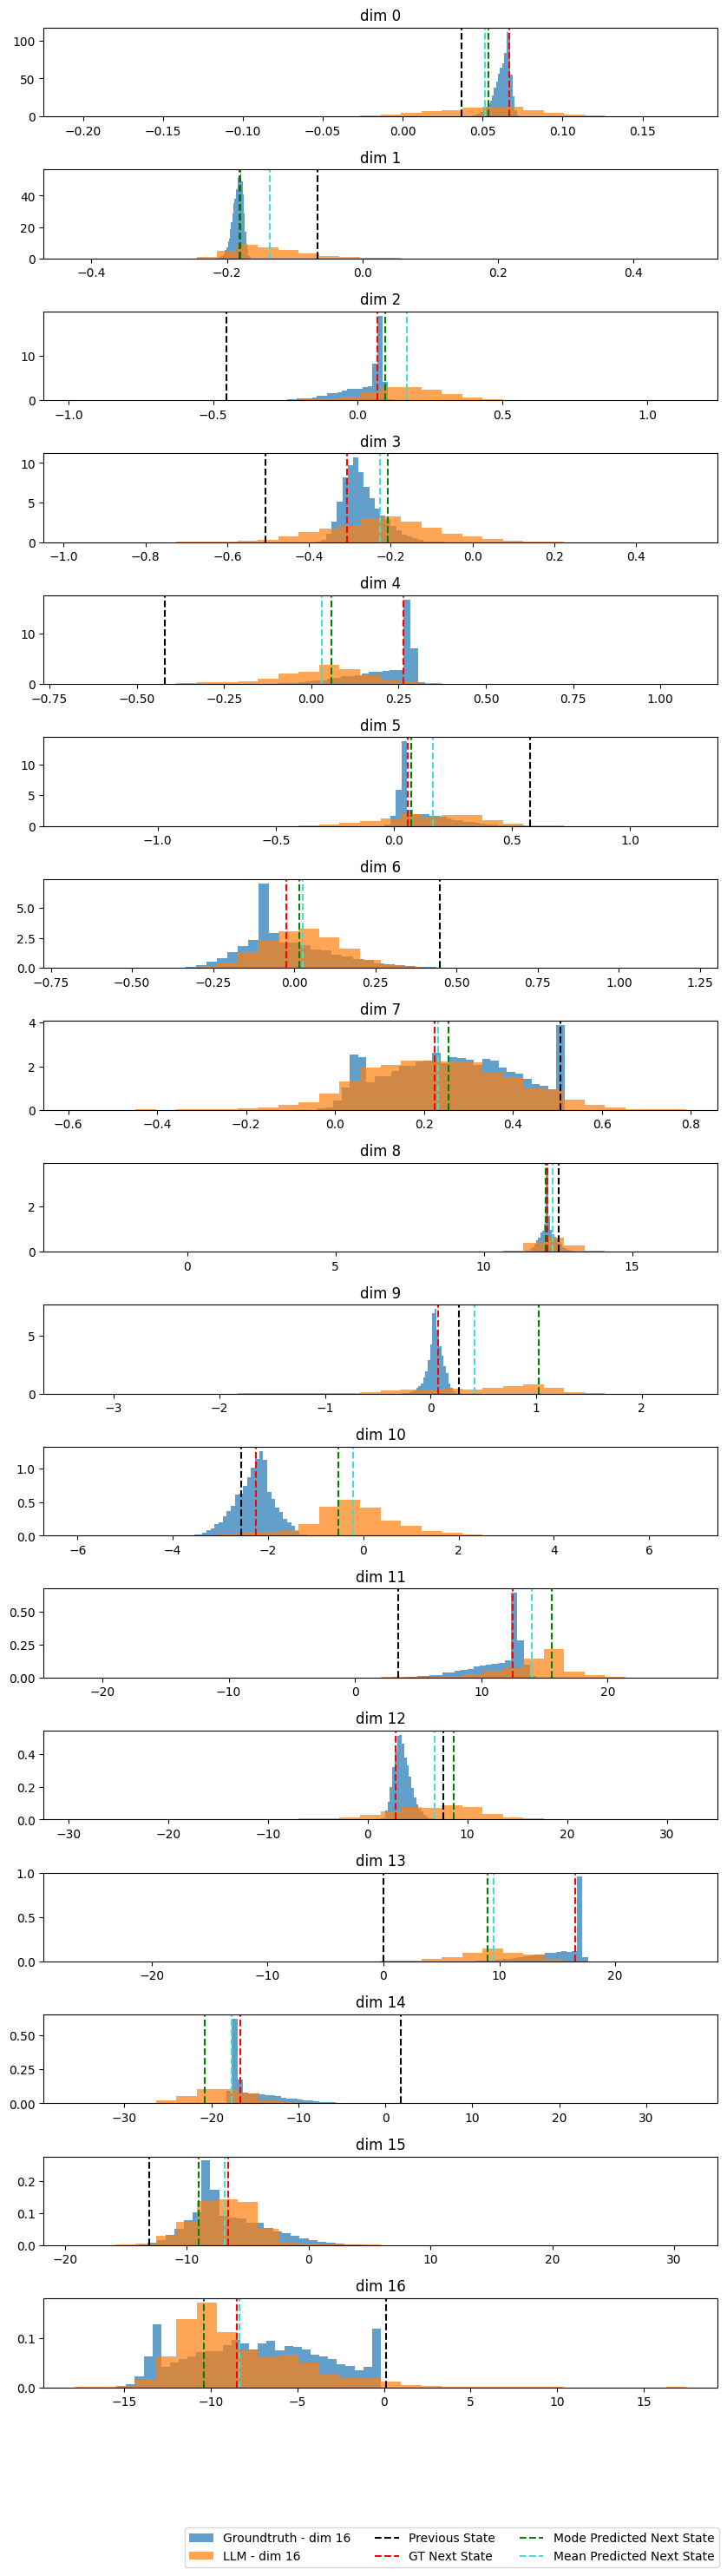

In [20]:
# Plot histogram of the next states
plt.figure(figsize=(10, 30))
for dim in range(next_states.shape[1]):
    groundtruth = data[init_index+1:init_index+context_length+1, dim].flatten()
    
    PDF = icl_object[dim].PDF_list[timestep]
    
    ts_min = icl_object[dim].rescaling_min
    ts_max = icl_object[dim].rescaling_max
    
    bin_center_arr = ((PDF.bin_center_arr - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min
    bin_height_arr = PDF.bin_height_arr / np.sum(PDF.bin_height_arr)

    llm_next_states = np.random.choice(
        bin_center_arr,
        p=PDF.bin_height_arr / np.sum(PDF.bin_height_arr),
        size=(num_samples,)
    )

    # mode and mean predictions
    mode_arr = ((icl_object[dim].mode_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min
    mean_arr = ((icl_object[dim].mean_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min
    
    plt.subplot(next_states.shape[1], 1, dim + 1)
    
    plt.hist(next_states[:, dim], bins=30, alpha=0.7, label=f'Groundtruth - dim {dim}', density=True)
    plt.hist(llm_next_states, bins=30, alpha=0.7, label=f'LLM - dim {dim}', density=True)
    # plt.bar(bin_center_arr, bin_height_arr, alpha = 1.0, label=f'LLM', color='green')
    plt.axvline(x=obs[dim], color='k', linestyle='--', label='Previous State')
    plt.axvline(x=groundtruth[timestep], color='r', linestyle='--', label='GT Next State')
    plt.axvline(x=mode_arr[timestep], color='green', linestyle='--', label='Mode Predicted Next State')
    plt.axvline(x=mean_arr[timestep], color='turquoise', linestyle='--', label='Mean Predicted Next State')
    
    # plt.xlim([X[:,dim].min(), X[:,dim].max()])

    plt.title(f"dim {dim}")

plt.legend(loc='center left', bbox_to_anchor=(0.2, -1.8), ncols=3)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the layout to make room for the legends

# plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the layout to make room for the legend

plt.show()

# Vizu: old plot - true errors Vs groundtruth aleatoric uncertainty Vs learned uncertainty

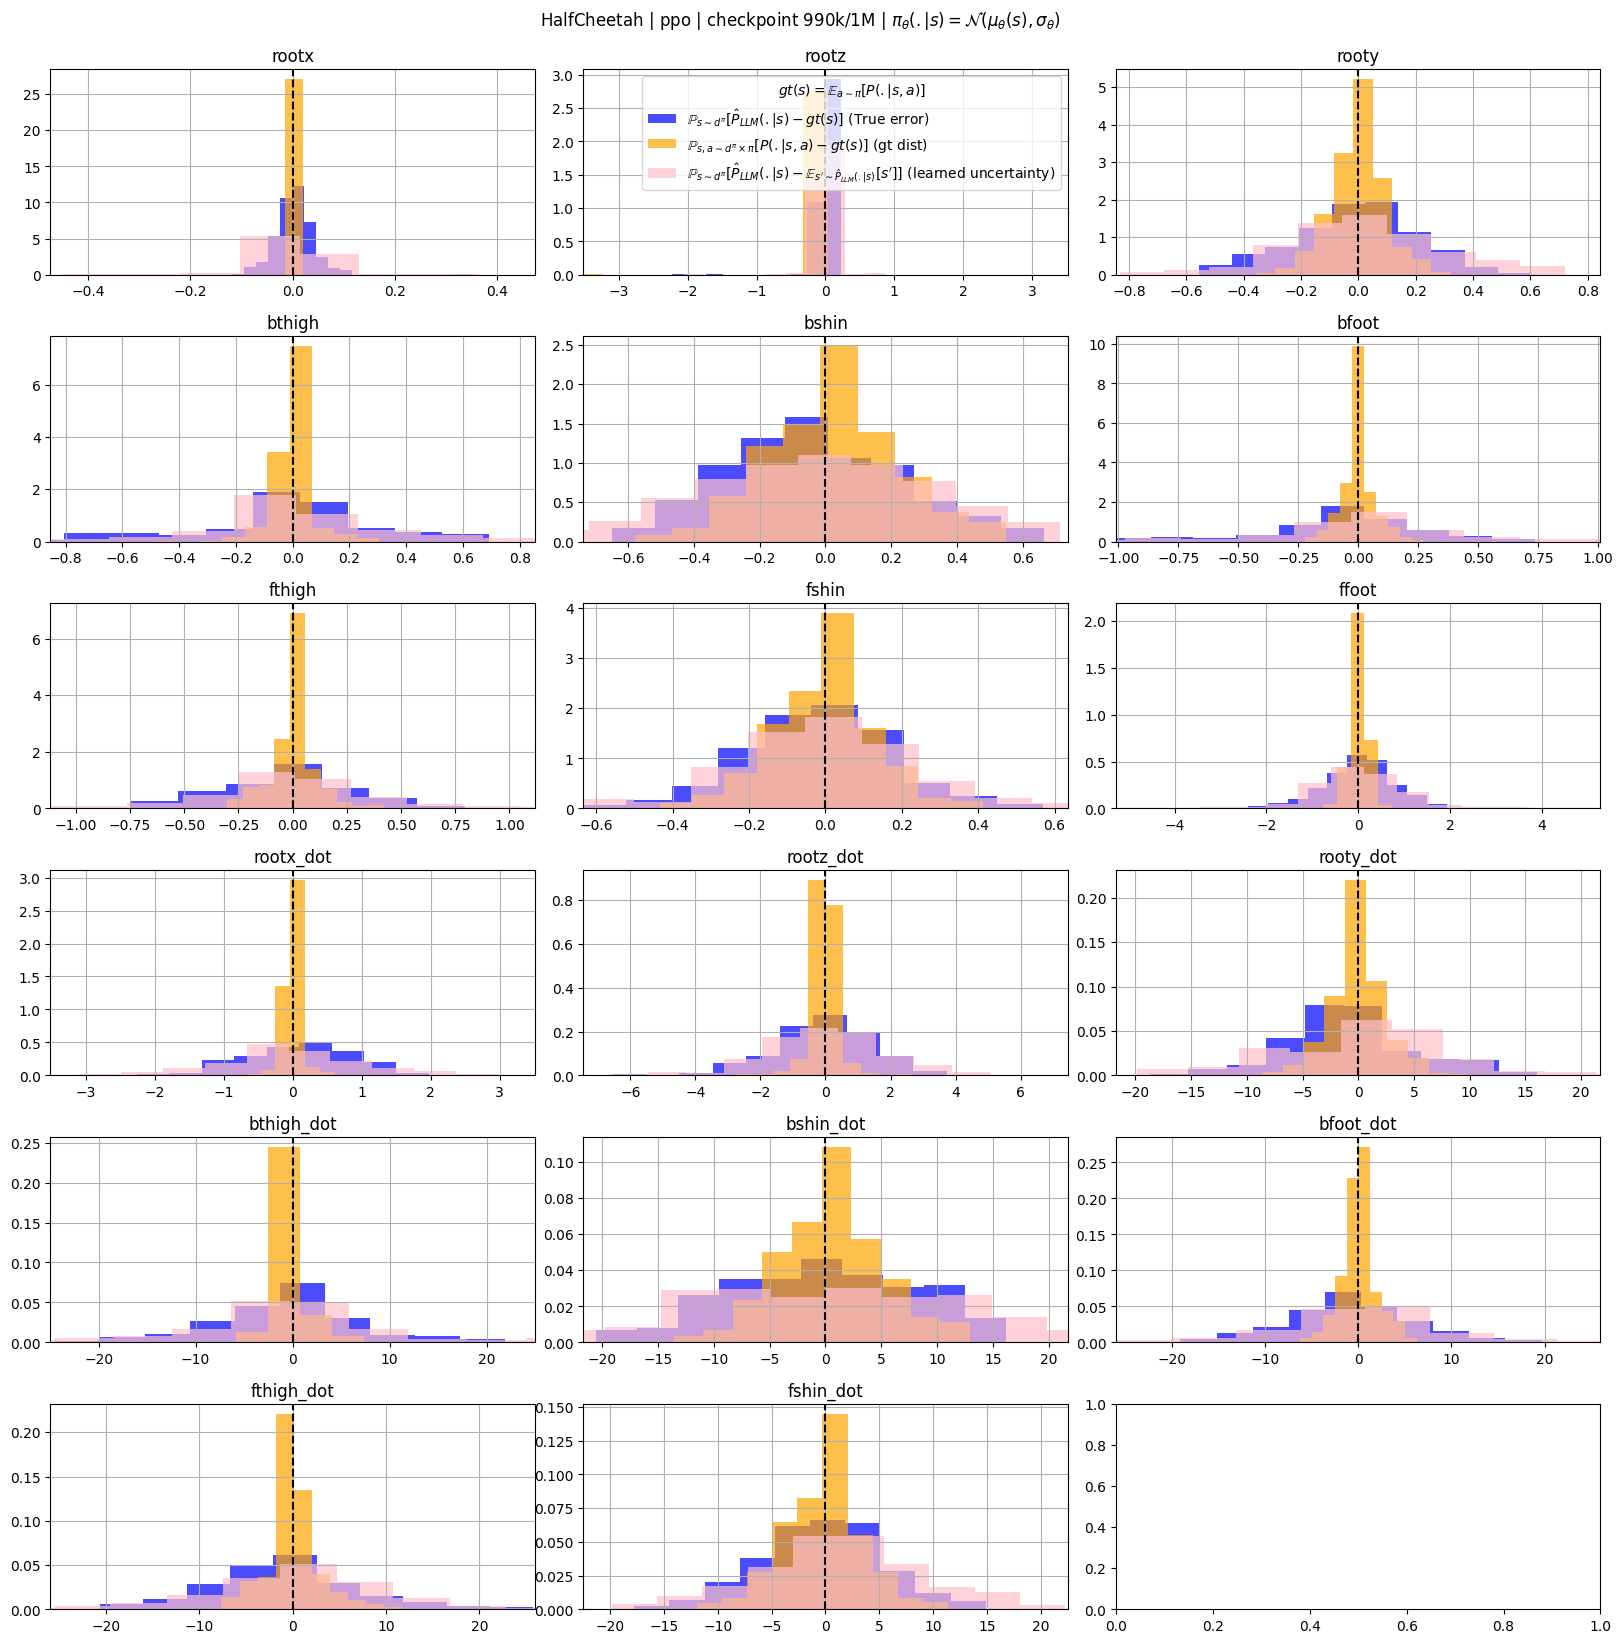

In [84]:
# groundtruth distribution
next_states = []
for t in range(len(episode_states)):
    obs, env_state = episode_states[init_index+t-1]
    obs_next, _ = episode_states[init_index+t]
    
    # policy dist parameters
    if algorithm=='sac':
        _, _, mean, std = actor.get_action(torch.Tensor(obs[None, ...]).to(device))
    elif algorithm=='td3':
        mean = actor(torch.Tensor(obs[None, ...]).to(device))
        std = actor.action_scale * 0.1  # 0.1 is exploitation_noise
    else:
        _, _, _, _, mean, std = actor.get_action_and_value(torch.Tensor(obs[None, ...]).to(device))
    
    mean = mean.cpu().detach().numpy()
    std = std.cpu().detach().numpy()
    
    action = np.random.normal(mean, std)
    set_mujoco_state(env, env_state)
    next_state, _, _, _, _ = env.step(action.flatten())
    next_states.append(next_state[None, ...])
next_states = np.concatenate(next_states, axis=0)

# epistemic uncertainty (from LLM logits)
llm_next_states = []
for t in range(len(icl_object[0].PDF_list)):  
    one_sample = []
    for dim in range(next_states.shape[1]):
        PDF = icl_object[dim].PDF_list[t]
        
        ts_min = icl_object[dim].rescaling_min
        ts_max = icl_object[dim].rescaling_max
        
        bin_center_arr = ((PDF.bin_center_arr - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min
        bin_height_arr = PDF.bin_height_arr / np.sum(PDF.bin_height_arr)
    
        one_sample.append(
            np.random.choice(
                bin_center_arr,
                p=PDF.bin_height_arr / np.sum(PDF.bin_height_arr),
            )
        )
    llm_next_states.append(np.array(one_sample)[None,...])
llm_next_states = np.concatenate(llm_next_states, axis=0)

f, axes = plt.subplots(6, 3, figsize=(20, 20), gridspec_kw={'wspace':0.1, 'hspace':0.3})
axes = list(np.array(axes).flatten())
for dim in range(next_states.shape[1]):
    groundtruth = data[init_index+1:init_index+context_length+1, dim].flatten()

    ts_min = icl_object[dim].rescaling_min
    ts_max = icl_object[dim].rescaling_max
    
    # mode and mean predictions
    mode_arr = ((icl_object[dim].mode_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min
    mean_arr = ((icl_object[dim].mean_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min

    #true error
    error_mode = groundtruth - mode_arr
    error_mean = groundtruth - mean_arr

    error_sampling = groundtruth - next_states[init_index:init_index+context_length, dim]
    uncertainty_estimate = mean_arr - llm_next_states[:, dim]

    start_from = 0

    legend_pred = r"$\mathbb{P}_{s \sim d^\pi}[\hat{P}_{LLM}(.|s) - gt(s)]$ (True error)"
    legend_gt = r"$\mathbb{P}_{s,a \sim d^\pi \times \pi}[P(.|s,a) - gt(s)]$ (gt dist)"
    legend_uncertainty = r"$\mathbb{P}_{s \sim d^\pi}[\hat{P}_{LLM}(.|s) - \mathbb{E}_{s' \sim \hat{P}_{LLM}(.|s)}[s']]$ (learned uncertainty)"
    axes[dim].hist(error_mean[start_from:], color='blue', alpha=0.7, label=legend_pred, density=True)
    axes[dim].hist(error_sampling[start_from:], color='orange', alpha=0.7, label=legend_gt, density=True)
    axes[dim].hist(uncertainty_estimate[start_from:], color='pink', alpha=0.7, label=legend_uncertainty, density=True)
    axes[dim].axvline(x=0, color='k', linestyle='--')
    axes[dim].set_title(f"{state_names[env_name][dim]}")
    dim_range = (X[:,dim].max() - X[:,dim].min()) / 2
    axes[dim].set_xlim([-dim_range, dim_range])
    if dim==1:
        axes[dim].legend(title=r"$gt(s)=\mathbb{E}_{a \sim \pi}[P(.|s,a)]$")
    axes[dim].grid(True)
fig_title = f'{env_name} | {algorithm} | checkpoint {int(policy_checkpoint/1000)}k/1M '
if algorithm=='sac':
    fig_title += r'| $\pi_\theta(.|s) = \mathcal{N}(\mu_\theta(s), \sigma_\theta(s))$'
elif algorithm=='td3':
    fig_title += r'| $\pi_\theta(.|s) = \mathcal{N}(\mu_\theta(s), \sigma)$'
elif algorithm=='ppo':
    fig_title += r'| $\pi_\theta(.|s) = \mathcal{N}(\mu_\theta(s), \sigma_\theta)$'
else:
    raise NotImplementedError
f.suptitle(fig_title, y=0.91)
# plt.savefig(f"/home/abenechehab/llmicl/src/llmicl/artifacts/figures/uncertainty|{env_name}_algo|{algorithm}_policy|{policy_checkpoint}.pdf")
plt.show()

# Vizu: Vasilii extension

In [21]:
# Number of samples
num_samples = 100

# groundtruth distribution
std_all_states = []
mean_all_states = []
for t in tqdm(range(len(episode_states)), desc='gt dist'):
    obs, env_state = episode_states[init_index+t-1]
    obs_next, _ = episode_states[init_index+t]
    
    # policy dist parameters
    if algorithm=='sac':
        _, _, mean, std = actor.get_action(torch.Tensor(obs[None, ...]).to(device))
    elif algorithm=='td3':
        mean = actor(torch.Tensor(obs[None, ...]).to(device))
        std = actor.action_scale * 0.1  # 0.1 is exploitation_noise
    else:
        _, _, _, _, mean, std = actor.get_action_and_value(torch.Tensor(obs[None, ...]).to(device))
    
    mean = mean.cpu().detach().numpy()
    std = std.cpu().detach().numpy()
    
    # Sample actions from the policy
    next_states = []
    for _ in range(num_samples):
        action = np.random.normal(mean, std)
        set_mujoco_state(env, env_state)
        next_state, _, _, _, _ = env.step(action.flatten())
        next_states.append(next_state[None, ...])
    
    # Convert to numpy array for easier manipulation
    next_states = np.concatenate(next_states, axis=0)
    std_all_states.append(next_states.std(axis=0)[None, ...])
    mean_all_states.append(next_states.mean(axis=0)[None, ...])
mean_all_states = np.concatenate(mean_all_states, axis=0)
std_all_states = np.concatenate(std_all_states, axis=0)


# epistemic uncertainty (from LLM logits)
llm_std_all_states = []
llm_mean_all_states = []
for t in tqdm(range(len(icl_object[0].PDF_list)), desc='llm dist'):  
    one_sample_mean = []
    one_sample_std = []
    for dim in range(next_states.shape[1]):
        PDF = icl_object[dim].PDF_list[t]
        
        ts_min = icl_object[dim].rescaling_min
        ts_max = icl_object[dim].rescaling_max
        
        bin_center_arr = ((PDF.bin_center_arr - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min
        bin_height_arr = PDF.bin_height_arr / np.sum(PDF.bin_height_arr)
    
        samples = np.random.choice(
            bin_center_arr,
            p=PDF.bin_height_arr / np.sum(PDF.bin_height_arr),
            size=(num_samples,)
        )
        one_sample_mean.append(samples.mean())
        one_sample_std.append(samples.std())
        
    llm_mean_all_states.append(np.array(one_sample_mean)[None,...])
    llm_std_all_states.append(np.array(one_sample_std)[None,...])

llm_mean_all_states = np.concatenate(llm_mean_all_states, axis=0)
llm_std_all_states = np.concatenate(llm_std_all_states, axis=0)

llm dist: 100%|███████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 516.99it/s]


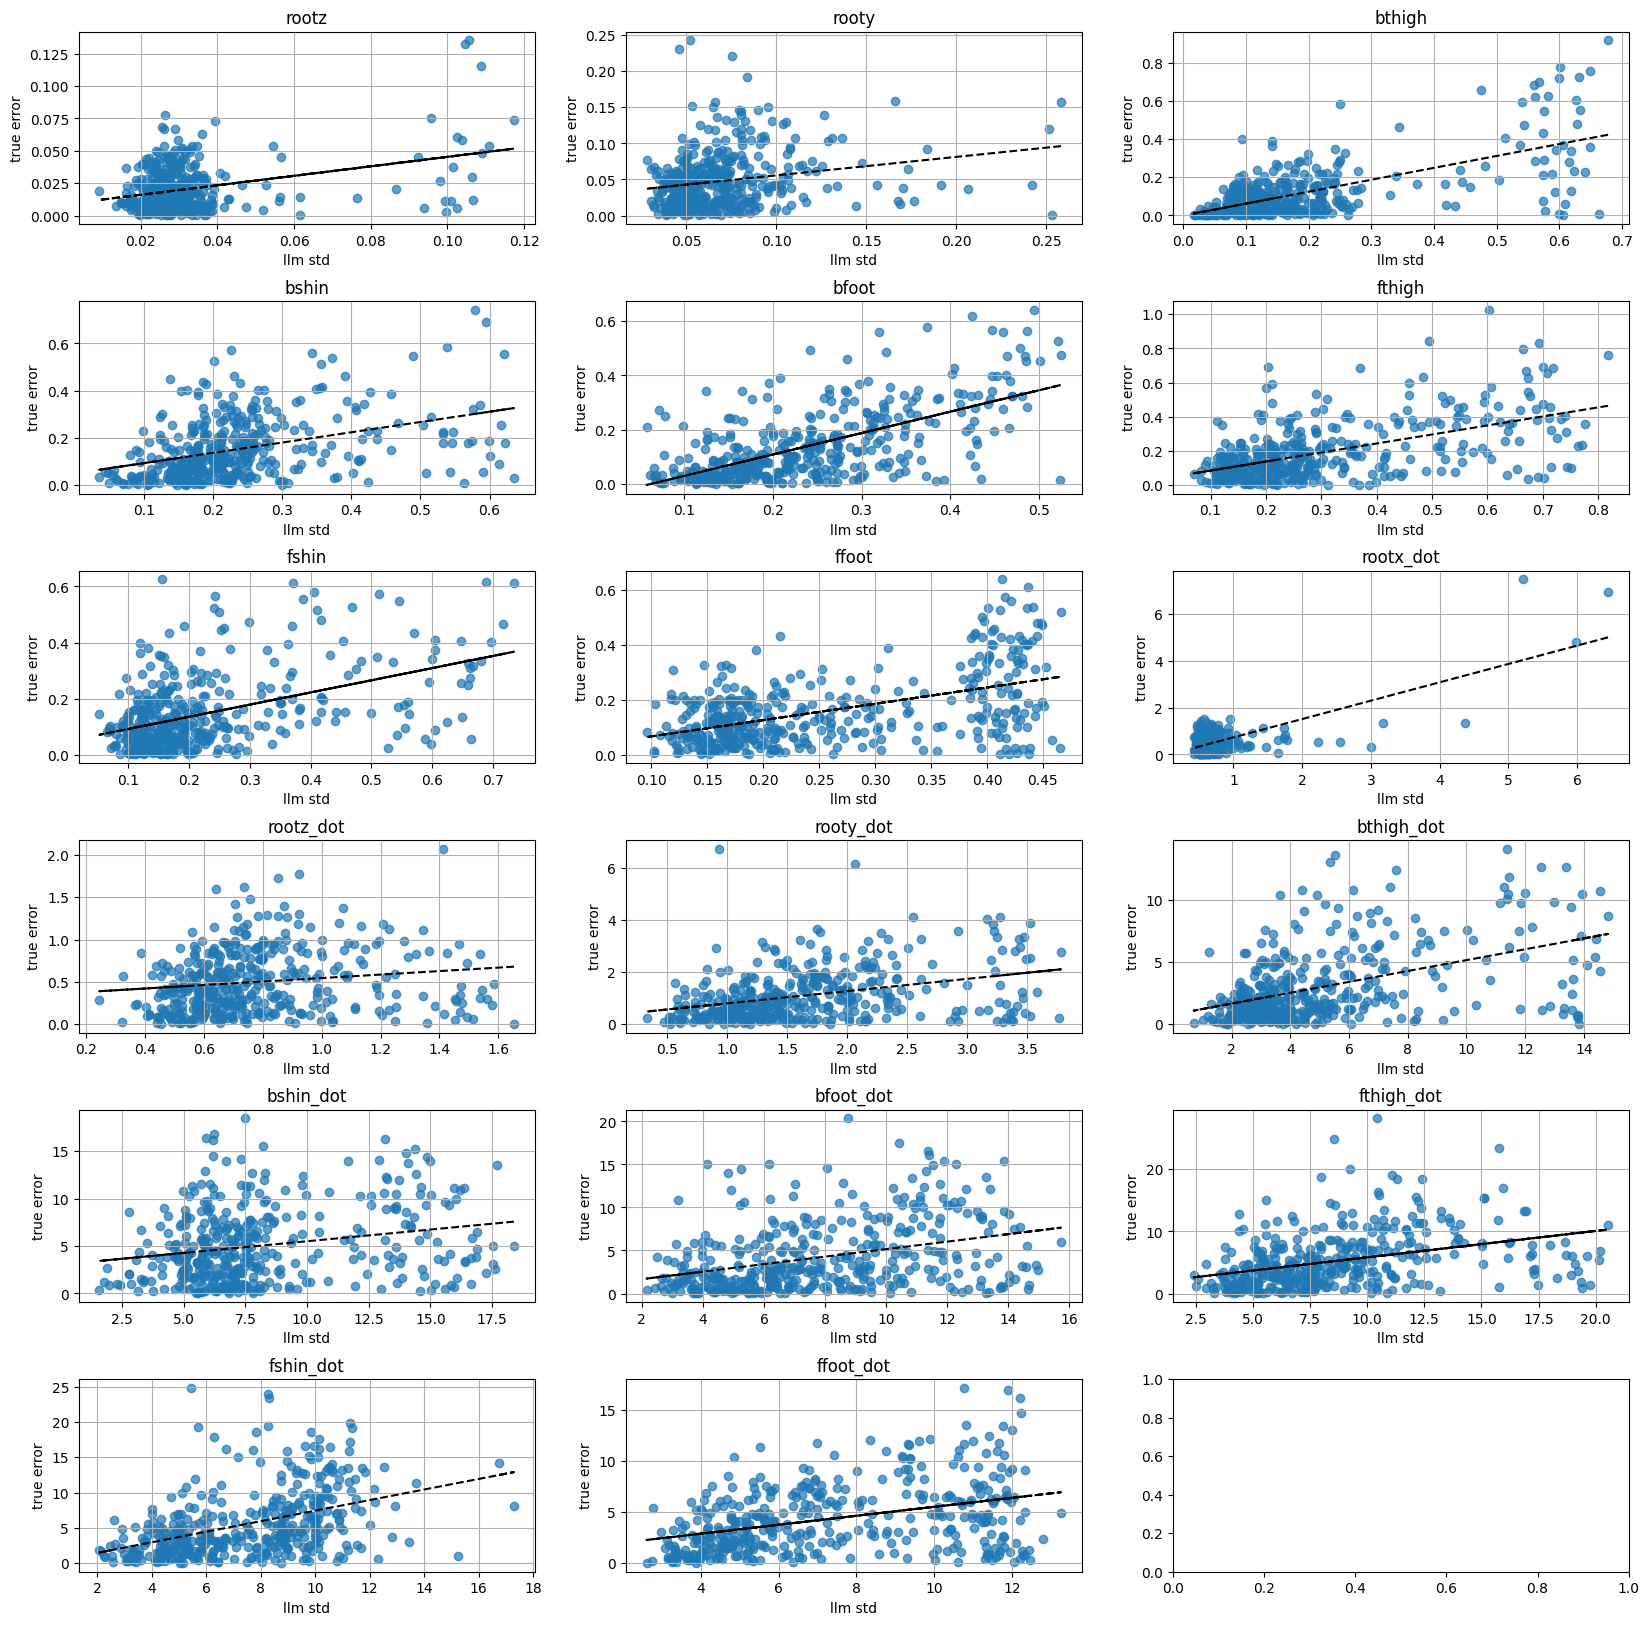

In [25]:
# -------------- plot -------------
f, axes = plt.subplots(6, 3, figsize=(20, 20), gridspec_kw={'wspace':0.2, 'hspace':0.4})
axes = list(np.array(axes).flatten())
for dim in range(next_states.shape[1]):    
    x = llm_std_all_states[:,dim]
    # y = std_all_states[init_index:init_index+context_length,dim]
    y = np.abs(llm_mean_all_states[:,dim] - mean_all_states[init_index:init_index+context_length,dim])
    
    results = sm.OLS(y,sm.add_constant(x)).fit()
    
    axes[dim].scatter(x, y, alpha=0.7)
    
    axes[dim].plot(x, x * results.params[1] + results.params[0], 'k--')
    
    axes[dim].set_title(f"{state_names[env_name][dim+1]}")
    axes[dim].grid(True)
    axes[dim].set_xlabel('llm std')
    # axes[dim].set_ylabel('gt std')
    axes[dim].set_ylabel('true error')

# fig_title = f'{env_name} | {algorithm} | checkpoint {int(policy_checkpoint/1000)}k/1M '
# f.suptitle(fig_title, y=0.91)
plt.savefig(f"/home/abenechehab/llmicl/src/llmicl/artifacts/figures/calib_scatter-{env_name}_algo-{algorithm}_policy-{policy_checkpoint}.png")
plt.show()

# Kolmogorov-Smirnov statistic

## helpers

In [15]:
from scipy.stats import uniform
from scipy.special import kolmogorov
from scipy.stats import kstwobign

In [66]:
def compute_ks_metric_baseline(data, n_traces):
    """
    Computes the KS metric for a given model and test dataset.

    Parameters:
    - X_test: DataFrame containing ground truth values.
    - model: A model that predicts a categorical distribution over a discretization of the ground truth variable.
    - target_column_names: List of target column names in X_test.
    - n_traces: Number of traces (samples) to generate for each prediction.
    - future_length: Number of future time steps to predict.

    Returns:
    - kss: Array containing the KS metrics for each target and horizon.
    """

    # shape of predictions: observations.reshape(n_samples, n_traces)
    # shape of groundtruth: (n_samples,) or (n_samples, 1)
    n_samples = len(icl_object[0].PDF_list)

    kss = np.zeros((n_observations,))
    ks_quantiles = np.zeros((n_observations, n_samples))
    for dim in range(n_observations):
        predictions = np.empty((n_samples, n_traces))
        for t in range(n_samples):
            samples = np.random.normal(
                loc=data[
                    init_index + 1 : init_index + context_length + 1,
                    dim,
                ].mean(),
                scale=data[
                    init_index + 1 : init_index + context_length + 1,
                    dim,
                ].std(),
                size=(n_traces,),
            )

            predictions[t, :] = copy.copy(samples)

        groundtruth = data[
            init_index + 1 : init_index + context_length + 1, dim
        ].flatten()

        # print(f"groundtruth: {groundtruth.shape}")
        # print(f"predictions: {predictions.shape}")
        # print(
        #     f"quantiles : {np.array([g > m for g, m in zip(groundtruth, predictions)]).shape}"
        # )

        # Compute quantiles
        quantiles = np.sort(
            np.array([g > m for g, m in zip(groundtruth, predictions)]).sum(axis=1)
        )
        quantiles = quantiles / n_traces

        # Compute KS metric
        kss[dim] = np.max(
            np.abs(quantiles - (np.arange(len(quantiles)) / len(quantiles)))
        )
        ks_quantiles[dim, :] = quantiles

    return kss, ks_quantiles


def compute_ks_metric(data, icl_object, n_traces):
    """
    Computes the KS metric for a given model and test dataset.

    Parameters:
    - X_test: DataFrame containing ground truth values.
    - model: A model that predicts a categorical distribution over a discretization of the ground truth variable.
    - target_column_names: List of target column names in X_test.
    - n_traces: Number of traces (samples) to generate for each prediction.
    - future_length: Number of future time steps to predict.

    Returns:
    - kss: Array containing the KS metrics for each target and horizon.
    """

    # shape of predictions: observations.reshape(n_samples, n_traces)
    # shape of groundtruth: (n_samples,) or (n_samples, 1)
    n_samples = len(icl_object[0].PDF_list)

    kss = np.zeros((n_observations,))
    ks_quantiles = np.zeros((n_observations, n_samples))
    for dim in range(n_observations):
        predictions = np.empty((n_samples, n_traces))
        for t in range(n_samples):
            PDF = icl_object[dim].PDF_list[t]

            ts_min = icl_object[dim].rescaling_min
            ts_max = icl_object[dim].rescaling_max

            bin_center_arr = ((PDF.bin_center_arr - up_shift) / rescale_factor) * (
                ts_max - ts_min
            ) + ts_min
            bin_height_arr = PDF.bin_height_arr / np.sum(PDF.bin_height_arr)

            samples = np.random.choice(
                bin_center_arr,
                p=bin_height_arr,
                size=(n_traces,),
            )

            predictions[t, :] = copy.copy(samples)

        groundtruth = data[
            init_index + 1 : init_index + context_length + 1, dim
        ].flatten()

        # print(f"groundtruth: {groundtruth.shape}")
        # print(f"predictions: {predictions.shape}")
        # print(
        #     f"quantiles : {np.array([g > m for g, m in zip(groundtruth, predictions)]).shape}"
        # )

        # Compute quantiles
        quantiles = np.sort(
            np.array([g > m for g, m in zip(groundtruth, predictions)]).sum(axis=1)
        )
        quantiles = quantiles / n_traces

        # Compute KS metric
        kss[dim] = np.max(
            np.abs(quantiles - (np.arange(len(quantiles)) / len(quantiles)))
        )
        ks_quantiles[dim, :] = quantiles

    return kss, ks_quantiles


def compute_ks_metric_pca(
    data, icl_object, n_traces, n_components, pca, scaler, n_original_comp
):
    """
    Computes the KS metric for a given model and test dataset.

    Parameters:
    - X_test: DataFrame containing ground truth values.
    - model: A model that predicts a categorical distribution over a discretization of the ground truth variable.
    - target_column_names: List of target column names in X_test.
    - n_traces: Number of traces (samples) to generate for each prediction.
    - future_length: Number of future time steps to predict.

    Returns:
    - kss: Array containing the KS metrics for each target and horizon.
    """

    # shape of predictions: observations.reshape(n_samples, n_traces)
    # shape of groundtruth: (n_samples,) or (n_samples, 1)
    n_samples = len(icl_object[0].PDF_list)

    kss = np.zeros((n_observations,))
    ks_quantiles = np.zeros((n_observations, n_samples))
    predictions = np.empty((n_samples, n_traces, n_components))
    for dim in range(n_components):
        for t in range(n_samples):
            PDF = icl_object[dim].PDF_list[t]

            ts_min = icl_object[dim].rescaling_min
            ts_max = icl_object[dim].rescaling_max

            bin_center_arr = ((PDF.bin_center_arr - up_shift) / rescale_factor) * (
                ts_max - ts_min
            ) + ts_min
            bin_height_arr = PDF.bin_height_arr / np.sum(PDF.bin_height_arr)

            samples = np.random.choice(
                bin_center_arr,
                p=bin_height_arr,
                size=(n_traces,),
            )

            predictions[t, :, dim] = copy.copy(samples)

    predictions = scaler.inverse_transform(
        pca.inverse_transform(predictions.reshape(-1, n_components))
    ).reshape((n_samples, n_traces, n_original_comp))

    for dim in range(n_observations):
        groundtruth = data[
            init_index + 1 : init_index + context_length + 1, dim
        ].flatten()

        # print(f"groundtruth: {groundtruth.shape}")
        # print(f"predictions: {predictions.shape}")
        # print(
        #     f"quantiles : {np.array([g > m for g, m in zip(groundtruth, predictions)]).shape}"
        # )

        # Compute quantiles
        quantiles = np.sort(
            np.array([g > m for g, m in zip(groundtruth, predictions[:, :, dim])]).sum(
                axis=1
            )
        )
        quantiles = quantiles / n_traces

        # Compute KS metric
        kss[dim] = np.max(
            np.abs(quantiles - (np.arange(len(quantiles)) / len(quantiles)))
        )
        ks_quantiles[dim, :] = quantiles

    return kss, ks_quantiles


def ks_cdf(
    ks_quantiles,
    dim,
    n_traces,
    ax,
    verbose=0,
    color="r",
    pot_cdf_uniform=True,
    label="",
    kss=None,
):
    quantiles = ks_quantiles[dim]

    x = quantiles
    n = len(quantiles)

    target = uniform(loc=0, scale=np.max(x))  # Uniform over [0, 1]
    cdfs = target.cdf(x)
    ecdfs = np.arange(n + 1, dtype=float) / n
    gaps = np.column_stack([cdfs - ecdfs[:n], ecdfs[1:] - cdfs])

    if verbose:
        Dn = np.max(gaps)
        Kn = np.sqrt(n) * Dn
        print("Dn=%f, sqrt(n)*Dn=%f" % (Dn, Kn))
        print(
            chr(10).join(
                [
                    "For a sample of size n drawn from a uniform distribution:",
                    " the approximate Kolmogorov probability that sqrt(n)*Dn>=%f is %f"
                    % (Kn, kolmogorov(Kn)),
                    " the approximate Kolmogorov probability that sqrt(n)*Dn<=%f is %f"
                    % (Kn, kstwobign.cdf(Kn)),
                ]
            )
        )

    m_label = label  # + f" - ks = {ks:.3f}"
    ax.step(
        np.concatenate([[0], x]), ecdfs, where="post", color=color, label=m_label, lw=2
    )
    if pot_cdf_uniform:
        ax.plot(np.concatenate([[0], x]), np.concatenate([[0], cdfs]), "--", color="red")
    ax.set_ylim([0, 1])

    # Add vertical lines marking Dn+ and Dn-
    iminus, iplus = np.argmax(gaps, axis=0)
    if np.abs(ecdfs[iminus] - cdfs[iminus]) >= np.abs(cdfs[iplus] - ecdfs[iplus + 1]):
        ax.vlines([x[iminus]], ecdfs[iminus], cdfs[iminus], color=color, lw=3)
    else:
        ax.vlines([x[iplus]], cdfs[iplus], ecdfs[iplus + 1], color=color, lw=3)

## application

In [102]:
# kss, ks_quantiles = compute_ks_metric(data, icl_object, n_traces=100)
if pca_with_actions:
    kss_s_a_pca, ks_quantiles_s_a_pca = compute_ks_metric_pca(
        data,
        icl_object,
        n_traces=100,
        n_components=n_components,
        pca=pca,
        scaler=scaling_pipeline_act,
        n_original_comp=n_original_comp,
    )
else:
    # kss, ks_quantiles = compute_ks_metric_pca(
    #     data,
    #     icl_object,
    #     n_traces=100,
    #     n_components=n_components,
    #     pca=pca,
    #     scaler=scaling_pipeline,
    #     n_original_comp=n_original_comp,
    # )
    kss_s_pca, ks_quantiles_s_pca = compute_ks_metric_pca(
        data,
        icl_object,
        n_traces=100,
        n_components=n_components,
        pca=pca,
        scaler=scaling_pipeline,
        n_original_comp=n_original_comp,
    )

kss_baseline, ks_quantiles_baseline = compute_ks_metric_baseline(data, n_traces=100)

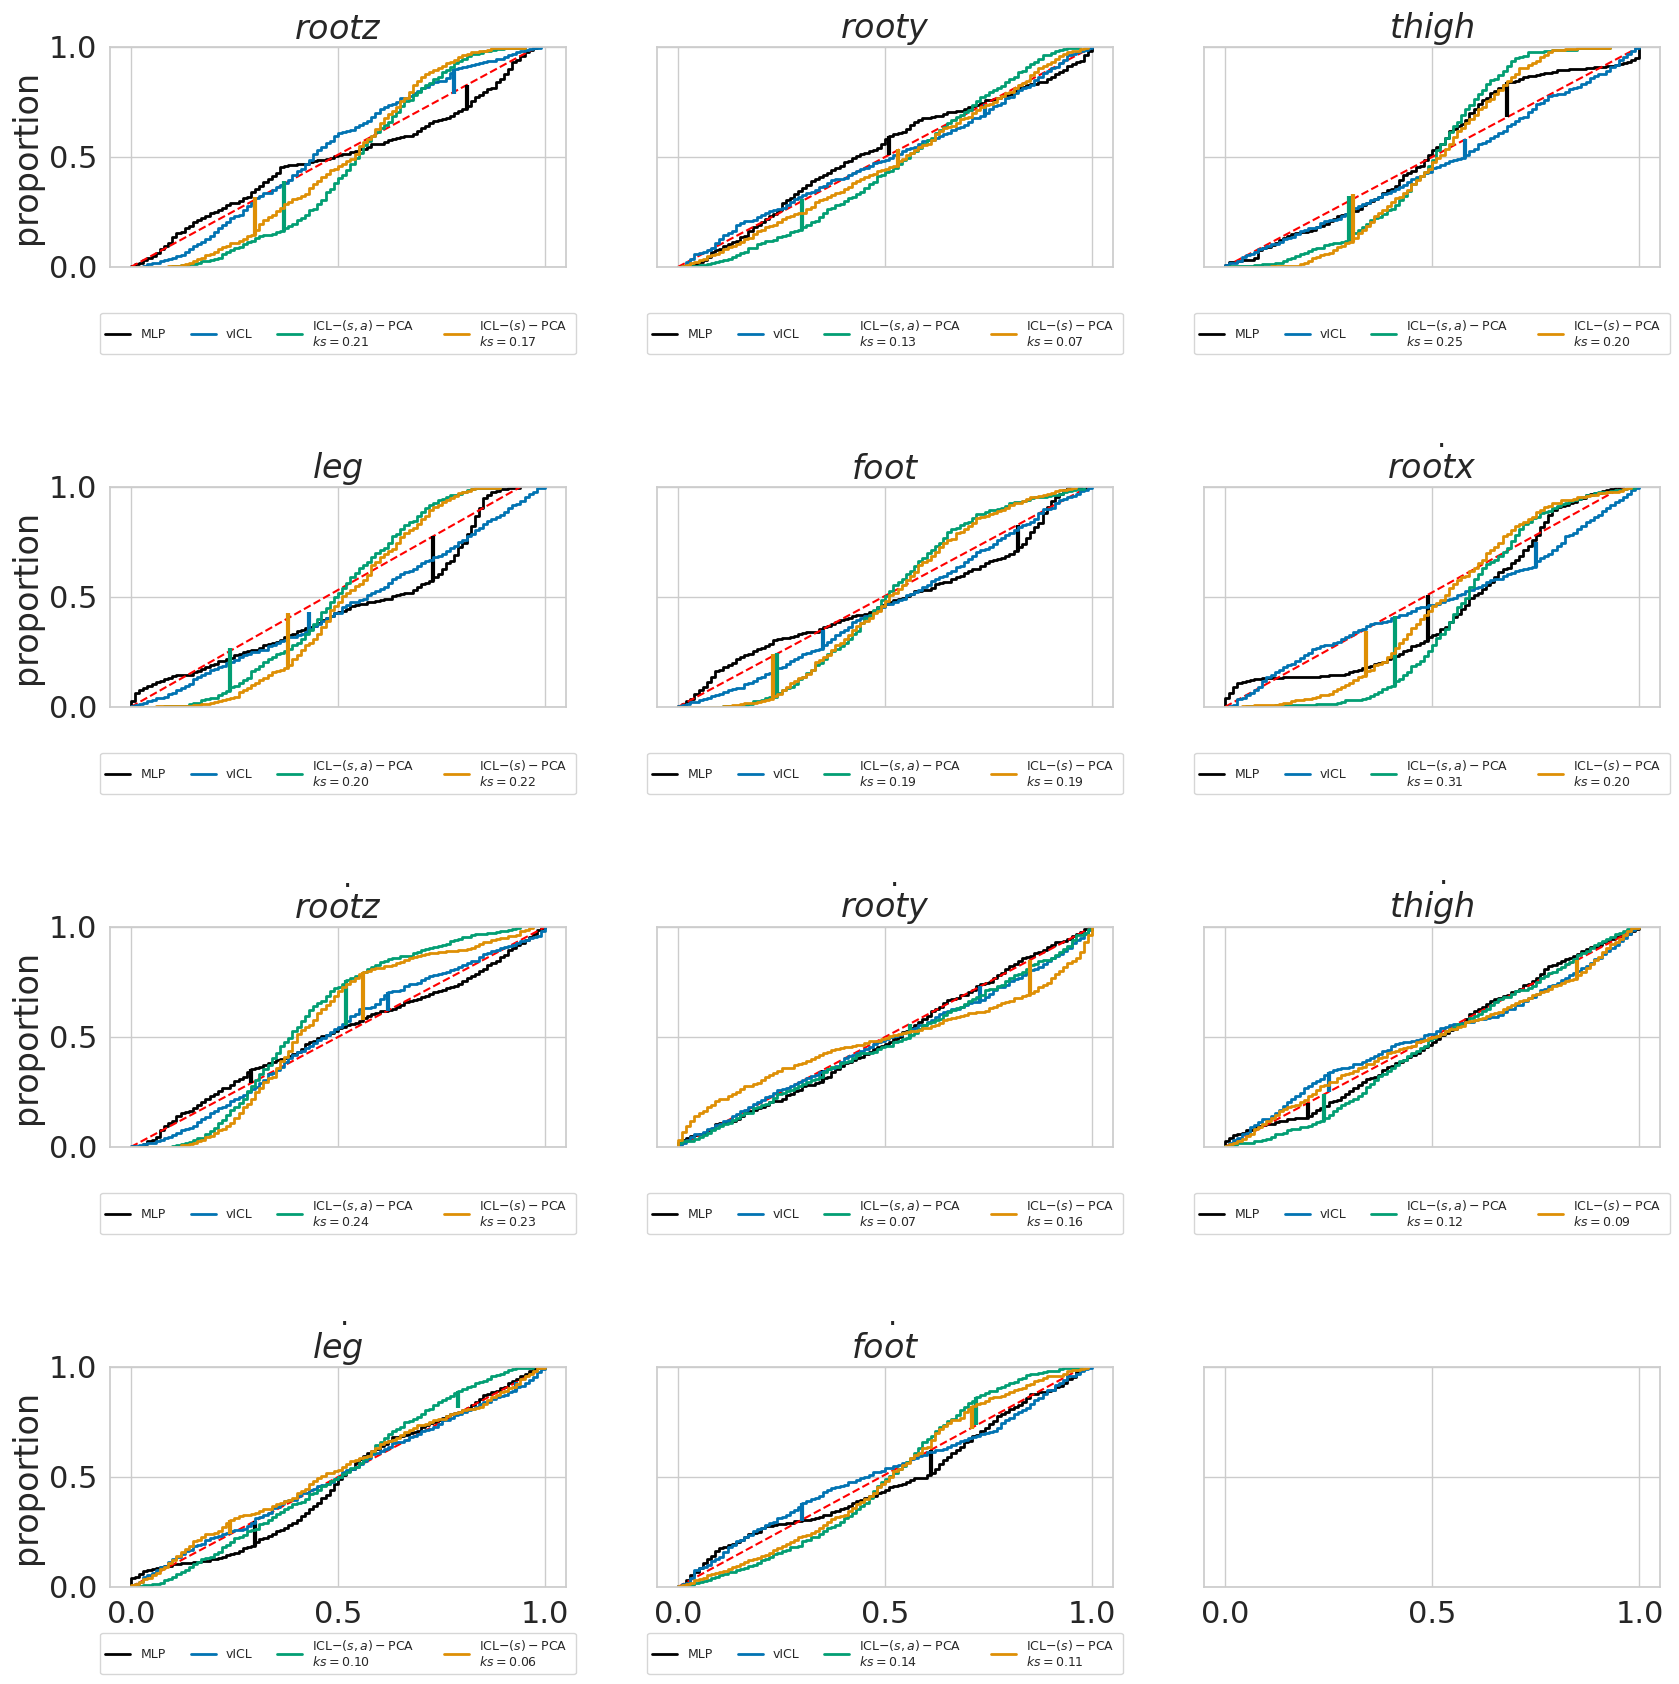

In [103]:
f, axes = plt.subplots(
    n_observations // 3 + 1,
    3,
    figsize=(20, 20),
    gridspec_kw={"wspace": 0.2, "hspace": 1.0},
    sharey=True,
    sharex=True,
)
axes = list(np.array(axes).flatten())
for dim in range(n_observations):
    # axes[dim].hist(ks_quantiles[dim,:], cumulative=True, density=True)
    # axes[dim].plot([0, 1.0], [0, 1.0], "r--")
    ks_cdf(
        ks_quantiles_baseline,
        dim,
        n_traces=100,
        ax=axes[dim],
        verbose=0,
        pot_cdf_uniform=True,
        color="black",
        kss=kss_baseline[dim],
        label=r"MLP",
    )
    ks_cdf(
        ks_quantiles,
        dim,
        n_traces=100,
        ax=axes[dim],
        verbose=0,
        pot_cdf_uniform=False,
        color=sns.color_palette("colorblind")[0],
        kss=kss[dim],
        label=r"vICL",
    )
    ks_cdf(
        ks_quantiles_s_a_pca,
        dim,
        n_traces=100,
        ax=axes[dim],
        verbose=0,
        pot_cdf_uniform=False,
        color=sns.color_palette("colorblind")[2],
        label=f"ICL$-(s,a)-$PCA  \n$ks={kss_s_a_pca[dim]:.2f}$",
    )
    ks_cdf(
        ks_quantiles_s_pca,
        dim,
        n_traces=100,
        ax=axes[dim],
        verbose=0,
        pot_cdf_uniform=False,
        color=sns.color_palette("colorblind")[1],
        label=f"ICL$-(s)-$PCA  \n$ks={kss_s_pca[dim]:.2f}$",
    )
    axes[dim].set_title(f"{state_names[env_name][dim]}")
    axes[dim].grid(True)
    if dim >= 15:
        axes[dim].set_xlabel("quantile")
        axes[dim].legend(
            loc="upper center", bbox_to_anchor=(0.5, -0.68), ncol=6, fontsize=9
        )
    else:
        axes[dim].legend(
            loc="upper center", bbox_to_anchor=(0.5, -0.18), ncol=6, fontsize=9
        )
    if dim % 3 == 0:
        axes[dim].set_ylabel("proportion")
plt.savefig(
    "/mnt/vdb/abenechehab/icl_paper/figures/"
    f"all_calibration-{env_name}_data-{data_label}.pdf",
    bbox_inches="tight",
)
plt.show()

<Figure size 640x480 with 0 Axes>

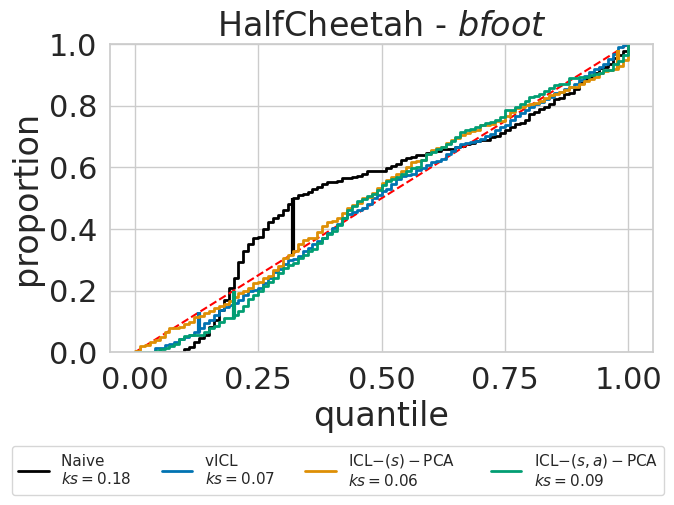

In [83]:
sns.set_theme(style="whitegrid", font_scale=2)
sns.set_palette("colorblind")
sns.despine()

dim = 4
# for dim in range(n_observations):
f, axes = plt.subplots(1, 1, figsize=(7, 4))
axes = list(np.array(axes).flatten())
# axes[dim].hist(ks_quantiles[dim,:], cumulative=True, density=True)
# axes[dim].plot([0, 1.0], [0, 1.0], "r--")
ks_cdf(
    ks_quantiles_baseline,
    dim,
    n_traces=100,
    ax=axes[0],
    verbose=0,
    pot_cdf_uniform=True,
    color="black",
    kss=kss_baseline[dim],
    label=f"Naive \n$ks={kss_baseline[dim]:.2f}$",
)
ks_cdf(
    ks_quantiles,
    dim,
    n_traces=100,
    ax=axes[0],
    verbose=0,
    pot_cdf_uniform=False,
    color=sns.color_palette("colorblind")[0],
    label=f"vICL \n$ks={kss[dim]:.2f}$",
)
ks_cdf(
    ks_quantiles_s_pca,
    dim,
    n_traces=100,
    ax=axes[0],
    verbose=0,
    pot_cdf_uniform=False,
    color=sns.color_palette("colorblind")[1],
    label=f"ICL$-(s)-$PCA  \n$ks={kss_s_pca[dim]:.2f}$",
)
ks_cdf(
    ks_quantiles_s_a_pca,
    dim,
    n_traces=100,
    ax=axes[0],
    verbose=0,
    pot_cdf_uniform=False,
    color=sns.color_palette("colorblind")[2],
    label=f"ICL$-(s,a)-$PCA \n$ks={kss_s_a_pca[dim]:.2f}$",
)
axes[0].set_title(f"{env_name} - {state_names[env_name][dim]}")
axes[0].grid(True)
axes[0].set_xlabel("quantile")
axes[0].legend(loc="upper center", bbox_to_anchor=(0.42, -0.28), ncol=6, fontsize=11)
axes[0].set_ylabel("proportion")
# axes[0].legend()
plt.savefig(
    "/mnt/vdb/abenechehab/icl_paper/figures/"
    f"calibration-{env_name}_data-{data_label}__dim{state_names[env_name][dim]}.pdf",
    bbox_inches="tight",
)
plt.show()

# Other

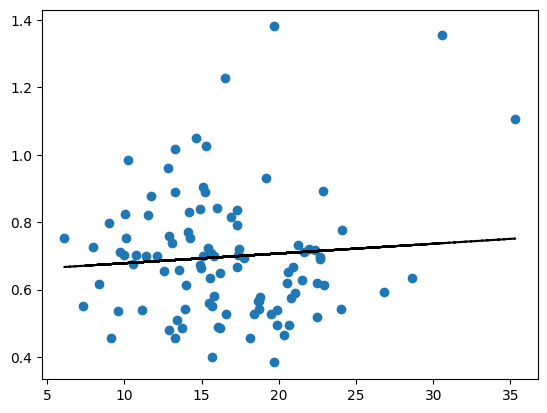

In [38]:
x = [14.16895893, 17.72118108, 19.90760116, 19.67490871,  8.97890511,
       12.12720743, 17.26132628, 13.5442745 , 13.7550354 , 22.83774503,
       30.54412159, 19.68889209, 35.30473981, 11.51849817, 10.74746987,
       13.27398401, 15.80156688, 13.2526269 , 22.67867689, 22.68439841,
        8.3679013 , 24.07872488,  7.94471541, 22.93583041, 15.52062893,
       19.88130764, 21.50969279, 11.42368525, 14.97588428, 14.0076376 ,
        9.72582934, 13.4125143 , 20.94330359, 17.27508727, 19.16708288,
        6.10238234, 10.58462108, 14.91038961, 20.52936792, 28.59901977,
       15.69965183, 14.23586942,  9.57203451, 22.44960966, 15.456284  ,
        9.09759527, 18.11795496, 12.88257599, 16.55282091, 12.59326203,
       12.85178877, 11.69105337,  7.3467821 , 16.01071842, 15.25110446,
       16.5203786 , 16.87061697, 17.44585412, 16.0456713 , 15.65293585,
       16.1952249 , 17.31655722, 16.21348564, 18.79400088, 18.3680536 ,
       10.01395848, 15.5768894 , 19.50263555, 20.64570708, 18.71535775,
       24.02379347, 15.08698052, 20.60109188, 10.12797782, 20.36351684,
       13.90583943, 18.67687499, 18.72861624, 22.44497801, 21.65460905,
       14.09991726, 22.32944761, 11.13302968, 14.91479536, 15.21706345,
       10.24394881, 13.27949641, 14.61509574, 12.86511299, 21.25787913,
       15.79811782, 21.94783814, 15.41301818,  9.98226547, 17.32432219,
       15.06089881, 13.05683558, 26.78384058, 21.05281351, 20.77739715]
y = [26.6734647 , 27.60538913, 26.69157766, 27.29086953, 27.21145691,
       26.96350038, 27.41379268, 26.75612284, 26.59490047, 27.33579771,
       27.41556612, 28.42069865, 27.33020832, 28.16367572, 27.50497513,
       27.10387991, 27.00601738, 26.19004165, 25.45042386, 26.18470591,
       26.04066661, 26.66871223, 25.99207849, 25.20821403, 25.91674893,
       25.22808505, 25.69677902, 25.19917231, 25.58590798, 25.44341835,
       25.64243345, 24.75188315, 24.29086518, 24.56465134, 24.88437545,
       25.40842221, 24.97098533, 24.32556536, 24.4749814 , 24.42251138,
       23.94473984, 24.68902881, 24.10604932, 24.35168048, 23.73580052,
       23.45713111, 23.43750311, 22.96068259, 23.73646968, 23.45449538,
       23.17298585, 23.63629368, 22.55705796, 22.70349185, 23.37021382,
       23.50583068, 22.73595732, 22.41740459, 22.62356611, 22.92268011,
       23.05305022, 22.49506224, 22.97149335, 23.23800033, 23.29423065,
       22.7806223 , 22.24388962, 22.45804403, 21.82722066, 21.6178291 ,
       21.84527942, 22.48596378, 22.75374646, 23.48656306, 22.30822948,
       22.31461082, 21.9957696 , 22.26950561, 22.70742883, 23.025989  ,
       23.32266026, 22.85878317, 23.51553051, 23.41744535, 23.02043236,
       23.0845436 , 23.2447013 , 22.70327312, 22.52029227, 22.90191956,
       22.86296631, 22.49411257, 22.10426074, 21.67195006, 21.75666485,
       22.09915053, 22.08961018, 21.96857259, 21.87954589, 21.68281996]
y0 = [0.8287987 , 0.69450795, 0.49421682, 0.38388118, 0.79870749,
       0.69847278, 0.7928757 , 0.65755496, 0.48641287, 0.89183617,
       1.35408558, 1.38051094, 1.10586974, 0.81997136, 0.70164008,
       0.89095621, 0.58115176, 0.45670944, 0.68934672, 0.69533321,
       0.61624348, 0.77621988, 0.72659959, 0.6143971 , 0.63441592,
       0.54076034, 0.62920838, 0.70086195, 0.66424742, 0.61370781,
       0.71172091, 0.50868603, 0.66675585, 0.83590664, 0.9300832 ,
       0.75415313, 0.67545188, 0.67252927, 0.61935961, 0.63586403,
       0.55203085, 0.75388387, 0.53658885, 0.51943769, 0.56152644,
       0.45672436, 0.45528156, 0.48005362, 0.5274549 , 0.65619136,
       0.95940751, 0.87785856, 0.55199476, 0.84254135, 1.0262038 ,
       1.22707294, 0.81655133, 0.72189663, 0.48851517, 0.40150715,
       0.48581692, 0.66768841, 0.64866305, 0.57731065, 0.52682213,
       0.82464532, 0.70865934, 0.52775824, 0.49528196, 0.54207518,
       0.54223272, 0.69994036, 0.65364527, 0.75433226, 0.46428055,
       0.54131882, 0.56608887, 0.56637053, 0.62051151, 0.71268732,
       0.76951714, 0.71858743, 0.54081082, 0.84025329, 0.89001281,
       0.98399774, 1.01786657, 1.05020911, 0.76008705, 0.73125362,
       0.69930775, 0.71983   , 0.72486379, 0.70263716, 0.70244948,
       0.90300594, 0.737525  , 0.59380878, 0.59105534, 0.57507471]
y1 = [1.39314907, 1.56464973, 1.38792016, 1.3846351 , 1.63073171,
       1.49254802, 1.41917868, 1.61227807, 1.60509213, 1.3893745 ,
       1.53184521, 1.43612107, 1.32653553, 1.59810894, 1.64872645,
       1.42331665, 1.67316173, 1.35933535, 1.42090669, 1.50694322,
       1.44868077, 1.47330595, 1.60352079, 1.4669624 , 1.37420044,
       1.47996524, 1.55983271, 1.3454693 , 1.71932956, 1.72967091,
       1.53642684, 1.45775544, 1.40367068, 1.48567522, 1.60620969,
       1.72986633, 1.62211944, 1.57180285, 1.65507952, 1.66645752,
       1.61127783, 1.67686126, 1.65605752, 1.56201092, 1.34587862,
       1.66663574, 1.62135986, 1.46701118, 1.73621606, 1.60360019,
       1.48012609, 1.76234897, 1.66520253, 1.46701454, 1.63655649,
       1.64154516, 1.64130715, 1.51161411, 1.57120905, 1.67892105,
       1.68122857, 1.62216689, 1.58751068, 1.52926259, 1.40389846,
       1.35088665, 1.45003931, 1.64703745, 1.53056446, 1.45491625,
       1.42301587, 1.42328541, 1.65670156, 1.64022484, 1.58723942,                                                   
       1.48078368, 1.46627728, 1.63911594, 1.59025906, 1.52360616,
       1.47799788, 1.6455786 , 1.70504327, 1.80773995, 1.69284509,
       1.59862951, 1.69528666, 1.65010817, 1.71500318, 1.69130229,
       1.60359823, 1.59190745, 1.53239369, 1.53663243, 1.57130954,
       1.52183334, 1.52303189, 1.49657151, 1.52490518, 1.43119101]

x = np.array(x)
y = np.array(y0)

results = sm.OLS(y,sm.add_constant(x)).fit()    
plt.plot(x, x * results.params[1] + results.params[0], 'k--')
plt.scatter(x,y)
plt.show()

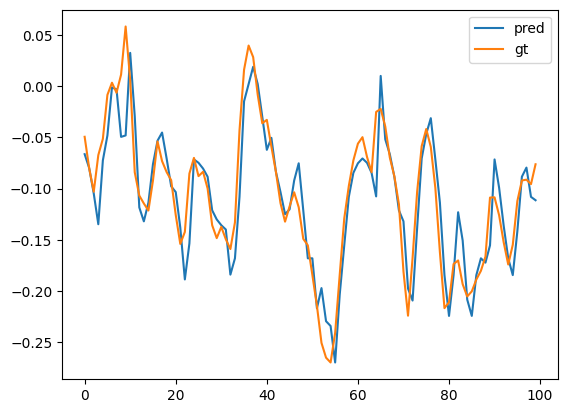

In [42]:
pred = np.array([-0.06628769, -0.07989537, -0.10476458, -0.13479532, -0.07238768,
       -0.04798771, -0.00106467, -0.00294159, -0.0493954 , -0.04798771,
        0.03271992, -0.02921849, -0.11837226, -0.13197994, -0.11367996,
       -0.07614153, -0.05314924, -0.04517232, -0.07051076, -0.09772612,
       -0.10335689, -0.13807994, -0.18875682, -0.15356454, -0.07144922,
       -0.07473384, -0.0803646 , -0.08834152, -0.12118764, -0.13010302,
       -0.13573378, -0.13995686, -0.18406451, -0.16811068, -0.10804919,
       -0.01467235,  0.00221994,  0.01911224,  0.00221994, -0.02968772,
       -0.06206462, -0.05033386, -0.08364921, -0.10335689, -0.12494149,
       -0.12024918, -0.09209536, -0.07520307, -0.12118764, -0.16811068,
       -0.16811068, -0.21691064, -0.19720296, -0.22957986, -0.23427216,
       -0.26993367, -0.20377219, -0.15544146, -0.10804919, -0.08458767,
       -0.07520307, -0.07051076, -0.07473384, -0.08458767, -0.10757996,
        0.01019686, -0.05174155, -0.06628769, -0.08834152, -0.12118764,
       -0.13197994, -0.19767219, -0.20940295, -0.13854917, -0.07051076,
       -0.04658001, -0.03109541, -0.07144922, -0.11367996, -0.18453374,
       -0.22441832, -0.18453374, -0.12306456, -0.15074916, -0.20846449,
       -0.22441832, -0.18453374, -0.16811068, -0.17233375, -0.15544146,
       -0.07144922, -0.09913382, -0.13620302, -0.16811068, -0.18453374,
       -0.14183378, -0.08834152, -0.07942614, -0.10804919, -0.11133381])
gt = np.array([-0.04930417, -0.0802142 , -0.10298721, -0.06721375, -0.05129289,
       -0.00833273,  0.00355264, -0.00625537,  0.01149597,  0.0585276 ,
        0.00606717, -0.08397799, -0.10679523, -0.11450202, -0.121391  ,
       -0.09203141, -0.05381719, -0.07309963, -0.0837945 , -0.09176461,
       -0.12569015, -0.15406029, -0.14232244, -0.08524247, -0.06993062,
       -0.08776709, -0.08351053, -0.09988669, -0.13575993, -0.14837375,
       -0.13739567, -0.14950171, -0.15904896, -0.13298121, -0.04307157,
        0.01619839,  0.03987745,  0.02857423, -0.00821945, -0.03607733,
       -0.03277102, -0.05890527, -0.083701  , -0.11415797, -0.1322625 ,
       -0.11731483, -0.10354675, -0.11819413, -0.1490569 , -0.15542999,
       -0.1844118 , -0.21456307, -0.2507793 , -0.26523843, -0.26993367,
       -0.24101396, -0.18439718, -0.12908985, -0.09739392, -0.0724334 ,
       -0.05601474, -0.04968566, -0.0690496 , -0.08395563, -0.02499036,
       -0.02204163, -0.03915638, -0.06947631, -0.08795991, -0.11522696,
       -0.18095563, -0.2242007 , -0.16778372, -0.10315062, -0.05842844,
       -0.04169805, -0.0592116 , -0.09929973, -0.16221173, -0.21681534,
       -0.21100627, -0.17367648, -0.17019999, -0.19341373, -0.20541252,
       -0.20042518, -0.18882859, -0.18035863, -0.16645786, -0.10872648,
       -0.10849379, -0.12599939, -0.15235995, -0.17415611, -0.1548793 ,
       -0.1122246 , -0.09201701, -0.09121933, -0.09557566, -0.07617129])
plt.figure()
plt.plot(np.arange(len(pred)), pred, label='pred')
plt.plot(np.arange(len(gt)), gt, label='gt')
plt.legend()
plt.show()

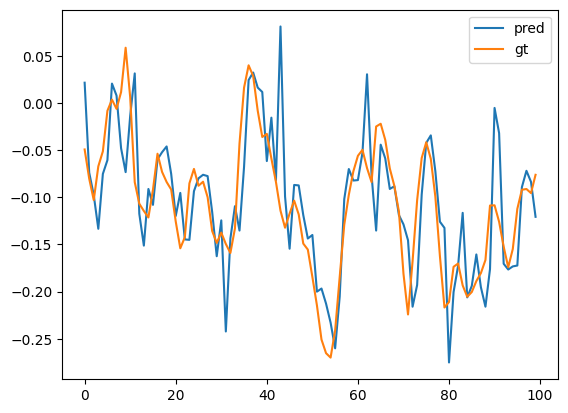

In [43]:
pred = np.array([0.02145839, -0.07379538, -0.09772612, -0.13338763, -0.07520307,
       -0.06065693,  0.02051993,  0.00785071, -0.04798771, -0.07332615,
       -0.01373389,  0.03131223, -0.1174338 , -0.15121839, -0.0911569 ,
       -0.10804919, -0.05971846, -0.05221078, -0.04611078, -0.07520307,
       -0.11977995, -0.09537997, -0.14464916, -0.14511839, -0.09350305,
       -0.07989537, -0.07614153, -0.07754922, -0.11555688, -0.16247992,
       -0.12447226, -0.24224908, -0.1437107 , -0.10945688, -0.13526455,
       -0.06769538,  0.02427377,  0.03225069,  0.01629686,  0.01160455,
       -0.06159539, -0.01561081, -0.08177229,  0.08105065, -0.09913382,
       -0.154503  , -0.08693383, -0.08740306, -0.11884149, -0.1437107 ,
       -0.13995686, -0.20001835, -0.19673373, -0.21268757, -0.23286447,
       -0.26007983, -0.20517988, -0.1019492 , -0.07004153, -0.08224152,
       -0.08177229, -0.05268001,  0.03037377, -0.07661076, -0.13526455,
       -0.04423386, -0.05878   , -0.0911569 , -0.08834152, -0.11884149,
       -0.12869533, -0.14558762, -0.21597218, -0.19297989, -0.09725689,
       -0.04235694, -0.03438002, -0.07238768, -0.12587995, -0.13244917,
       -0.2750952 , -0.20048758, -0.17233375, -0.11649534, -0.20611834,
       -0.19391835, -0.16060299, -0.19532604, -0.21597218, -0.1760876 ,
       -0.00528774, -0.03203387, -0.17045683, -0.17655683, -0.17327221,
       -0.17233375, -0.08927998, -0.07191845, -0.08364921, -0.12071841])
gt = np.array([-0.04930417, -0.0802142 , -0.10298721, -0.06721375, -0.05129289,
       -0.00833273,  0.00355264, -0.00625537,  0.01149597,  0.0585276 ,
        0.00606717, -0.08397799, -0.10679523, -0.11450202, -0.121391  ,
       -0.09203141, -0.05381719, -0.07309963, -0.0837945 , -0.09176461,
       -0.12569015, -0.15406029, -0.14232244, -0.08524247, -0.06993062,
       -0.08776709, -0.08351053, -0.09988669, -0.13575993, -0.14837375,
       -0.13739567, -0.14950171, -0.15904896, -0.13298121, -0.04307157,
        0.01619839,  0.03987745,  0.02857423, -0.00821945, -0.03607733,
       -0.03277102, -0.05890527, -0.083701  , -0.11415797, -0.1322625 ,
       -0.11731483, -0.10354675, -0.11819413, -0.1490569 , -0.15542999,
       -0.1844118 , -0.21456307, -0.2507793 , -0.26523843, -0.26993367,
       -0.24101396, -0.18439718, -0.12908985, -0.09739392, -0.0724334 ,
       -0.05601474, -0.04968566, -0.0690496 , -0.08395563, -0.02499036,
       -0.02204163, -0.03915638, -0.06947631, -0.08795991, -0.11522696,
       -0.18095563, -0.2242007 , -0.16778372, -0.10315062, -0.05842844,
       -0.04169805, -0.0592116 , -0.09929973, -0.16221173, -0.21681534,
       -0.21100627, -0.17367648, -0.17019999, -0.19341373, -0.20541252,
       -0.20042518, -0.18882859, -0.18035863, -0.16645786, -0.10872648,
       -0.10849379, -0.12599939, -0.15235995, -0.17415611, -0.1548793 ,
       -0.1122246 , -0.09201701, -0.09121933, -0.09557566, -0.07617129])
plt.figure()
plt.plot(np.arange(len(pred)), pred, label='pred')
plt.plot(np.arange(len(gt)), gt, label='gt')
plt.legend()
plt.show()

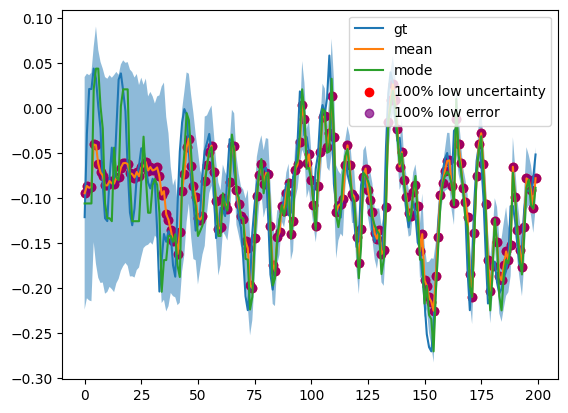

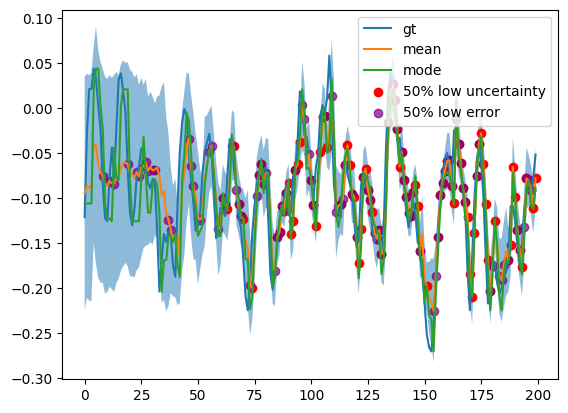

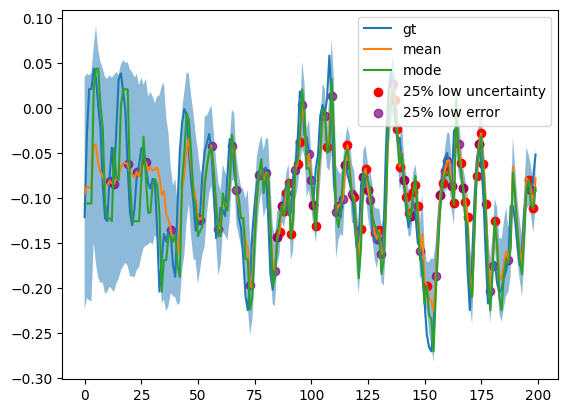

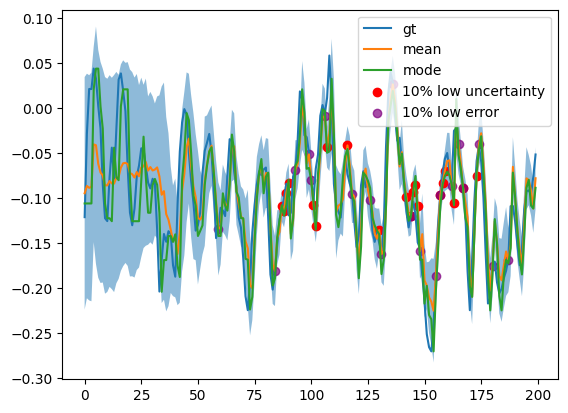

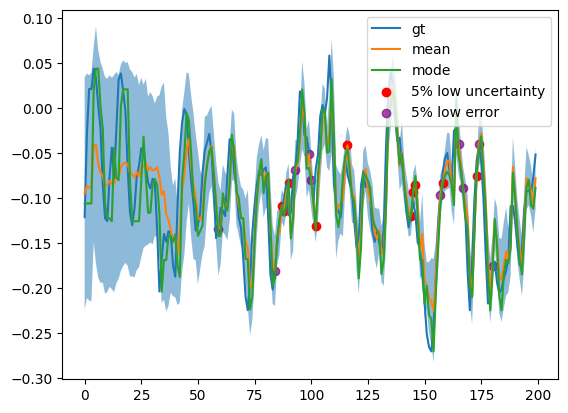

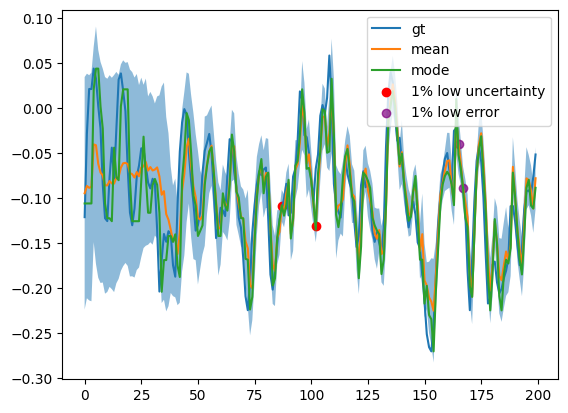

In [74]:
pred_mode = np.array([-0.10570304, -0.10570304, -0.10570304, -0.10570304,  0.02098916,
        0.04398145,  0.04398145,  0.00221994, -0.02264927, -0.10570304,
       -0.1221261 , -0.1221261 , -0.12541072, -0.04376463, -0.07661076,
       -0.07989537,  0.00221994,  0.02098916,  0.02098916,  0.02098916,
       -0.07989537, -0.12541072, -0.12541072, -0.12541072, -0.12541072,
       -0.07989537, -0.03156464, -0.07614153, -0.11602611, -0.11602611,
       -0.0850569 , -0.07848768, -0.0850569 , -0.11602611, -0.20377219,
       -0.16857991, -0.16857991, -0.14183378, -0.14183378, -0.148403  ,
       -0.13995686, -0.17467991, -0.18734913, -0.07989537, -0.05033386,
       -0.00528774, -0.01326466, -0.04986463, -0.09678766, -0.10804919,
       -0.14183378, -0.13620302, -0.13010302, -0.0850569 , -0.06394154,
       -0.04798771, -0.0432954 , -0.07144922, -0.10711073, -0.14183378,
       -0.14183378, -0.09444151, -0.10804919, -0.11367996, -0.0850569 ,
       -0.02921849, -0.04798771, -0.09256459, -0.09913382, -0.1221261 ,
       -0.1221261 , -0.16717222, -0.16811068, -0.22347986, -0.20940295,
       -0.148403  , -0.10054151, -0.07144922, -0.05643385, -0.09444151,
       -0.07614153, -0.07144922, -0.13010302, -0.19673373, -0.18875682,
       -0.14324147, -0.12494149, -0.10757996, -0.11931072, -0.10757996,
       -0.07942614, -0.14464916, -0.1221261 , -0.06394154, -0.05831077,
       -0.02921849,  0.02098916, -0.00528774, -0.06722615, -0.06628769,
       -0.07989537, -0.10476458, -0.13479532, -0.07238768, -0.04798771,
       -0.00106467, -0.00294159, -0.0493954 , -0.04798771,  0.03271992,
       -0.02921849, -0.11837226, -0.13197994, -0.11367996, -0.07614153,
       -0.05314924, -0.04517232, -0.07051076, -0.09772612, -0.10335689,
       -0.13807994, -0.18875682, -0.15356454, -0.07144922, -0.07473384,
       -0.0803646 , -0.08834152, -0.12118764, -0.13010302, -0.13573378,
       -0.13995686, -0.18406451, -0.16811068, -0.10804919, -0.01467235,
        0.00221994,  0.01911224,  0.00221994, -0.02968772, -0.06206462,
       -0.05033386, -0.08364921, -0.10335689, -0.12494149, -0.12024918,
       -0.09209536, -0.07520307, -0.12118764, -0.16811068, -0.16811068,
       -0.21691064, -0.19720296, -0.22957986, -0.23427216, -0.26993367,
       -0.20377219, -0.15544146, -0.10804919, -0.08458767, -0.07520307,
       -0.07051076, -0.07473384, -0.08458767, -0.10757996,  0.01019686,
       -0.05174155, -0.06628769, -0.08834152, -0.12118764, -0.13197994,
       -0.19767219, -0.20940295, -0.13854917, -0.07051076, -0.04658001,
       -0.03109541, -0.07144922, -0.11367996, -0.18453374, -0.22441832,
       -0.18453374, -0.12306456, -0.15074916, -0.20846449, -0.22441832,
       -0.18453374, -0.16811068, -0.17233375, -0.15544146, -0.07144922,
       -0.09913382, -0.13620302, -0.16811068, -0.18453374, -0.14183378,
       -0.08834152, -0.07942614, -0.10804919, -0.11133381, -0.08834152])
pred = np.array([-0.09441825, -0.08629953, -0.08833576, -0.08732746, -0.04014504,
       -0.04106391, -0.06170268, -0.07124032, -0.07475032, -0.08562778,
       -0.08563905, -0.08079461, -0.0834966 , -0.08363573, -0.07700209,
       -0.07620138, -0.06591031, -0.06105941, -0.06066427, -0.0619042 ,
       -0.07189137, -0.07321859, -0.07695635, -0.0707931 , -0.07551902,
       -0.06568241, -0.06459482, -0.05984602, -0.06919242, -0.06531596,
       -0.06909908, -0.06802398, -0.06569637, -0.07574552, -0.096026  ,
       -0.09203513, -0.11754573, -0.12378753, -0.13494904, -0.14717117,
       -0.14398623, -0.16181883, -0.1375362 , -0.0915645 , -0.07251288,
       -0.04335388, -0.03370344, -0.06433484, -0.08628914, -0.09873994,
       -0.12151538, -0.12366252, -0.11962909, -0.08102661, -0.0625969 ,
       -0.04829615, -0.0415171 , -0.07029186, -0.10312244, -0.1340025 ,
       -0.13234164, -0.09996727, -0.10587279, -0.11153571, -0.08158799,
       -0.04144649, -0.04230423, -0.09112445, -0.10661001, -0.12004427,
       -0.12315701, -0.14769739, -0.15544698, -0.19657051, -0.19978861,
       -0.14363866, -0.09743592, -0.07383107, -0.06152004, -0.08402429,
       -0.0719623 , -0.0724932 , -0.13101225, -0.17362982, -0.18064828,
       -0.14346639, -0.13738635, -0.10821976, -0.11389851, -0.09431644,
       -0.08257119, -0.1395925 , -0.1251283 , -0.06821413, -0.06210546,
       -0.03802908,  0.00305168, -0.01195389, -0.06122534, -0.05120499,
       -0.07923494, -0.10714479, -0.130819  , -0.0864135 , -0.04815656,
       -0.01001248, -0.00896331, -0.04316819, -0.02776486,  0.01368335,
       -0.03142627, -0.11503012, -0.10817738, -0.10621584, -0.10067859,
       -0.06294238, -0.04127524, -0.06277332, -0.09477299, -0.09822565,
       -0.14279121, -0.17218404, -0.13433539, -0.07641087, -0.06697991,
       -0.09054408, -0.10220798, -0.11470017, -0.13901314, -0.14485331,
       -0.13518479, -0.1620102 , -0.15793538, -0.11009033, -0.01577663,
        0.00894324,  0.02647068,  0.00911355, -0.02337876, -0.06473016,
       -0.04875408, -0.07998817, -0.09907195, -0.11631478, -0.11947687,
       -0.09243496, -0.08480438, -0.10824709, -0.15852652, -0.13979618,
       -0.19122936, -0.19688174, -0.20997578, -0.21472486, -0.22467727,
       -0.18672471, -0.14252704, -0.09661036, -0.08309762, -0.06912923,
       -0.05861179, -0.0578438 , -0.08676463, -0.10480263, -0.01229882,
       -0.03965451, -0.06032961, -0.08811831, -0.1039073 , -0.121133  ,
       -0.18365349, -0.2090812 , -0.13817768, -0.07468427, -0.04024588,
       -0.02778892, -0.06166331, -0.1057816 , -0.16903432, -0.20257686,
       -0.17519249, -0.12519762, -0.14904548, -0.1859556 , -0.19100515,
       -0.17429273, -0.1590105 , -0.1685905 , -0.15186698, -0.06502968,
       -0.09865943, -0.13552361, -0.15693579, -0.17571036, -0.13203209,
       -0.07784692, -0.07984873, -0.09129844, -0.1113034 , -0.07772626])
gt = np.array([-0.1209065 , -0.02790003,  0.02138726,  0.02134021,  0.04404528,
        0.03309153,  0.00255736, -0.02243064, -0.08487421, -0.12212089,
       -0.12530848, -0.07640856, -0.04374358, -0.07831261, -0.02430159,
        0.03184051,  0.03870096,  0.01919862, -0.00325121, -0.06631227,
       -0.11580876, -0.12989181, -0.11134464, -0.0755993 , -0.06361017,
       -0.04450176, -0.04581488, -0.06418338, -0.08258419, -0.08904731,
       -0.07829148, -0.08318292, -0.13520251, -0.20350839, -0.16811125,
       -0.13958663, -0.14826299, -0.13651004, -0.13953926, -0.17425138,
       -0.18699354, -0.10681087, -0.04814116, -0.01598488, -0.00094759,
       -0.00680474, -0.04979894, -0.08065163, -0.10440528, -0.13590093,
       -0.12967566, -0.11555903, -0.07211319, -0.04723504, -0.03829737,
       -0.02851012, -0.04989237, -0.09159172, -0.14413227, -0.13229017,
       -0.11047042, -0.11351949, -0.11971473, -0.07402058, -0.03436253,
       -0.03632047, -0.07036723, -0.08793228, -0.12158582, -0.13259657,
       -0.16704792, -0.20877557, -0.22419208, -0.19337805, -0.13810158,
       -0.10757498, -0.08438604, -0.06990272, -0.07427704, -0.06801566,
       -0.06582908, -0.12141036, -0.18459539, -0.20135762, -0.17934874,
       -0.15125345, -0.12334567, -0.11377778, -0.10022111, -0.08386604,
       -0.11891852, -0.11599366, -0.07575703, -0.06701022, -0.03592859,
        0.01869529,  0.00971171, -0.02999113, -0.03209649, -0.04930417,
       -0.0802142 , -0.10298721, -0.06721375, -0.05129289, -0.00833273,
        0.00355264, -0.00625537,  0.01149597,  0.0585276 ,  0.00606717,
       -0.08397799, -0.10679523, -0.11450202, -0.121391  , -0.09203141,
       -0.05381719, -0.07309963, -0.0837945 , -0.09176461, -0.12569015,                                                                                                                  -0.15406029, -0.14232244, -0.08524247, -0.06993062, -0.08776709,
       -0.08351053, -0.09988669, -0.13575993, -0.14837375, -0.13739567,
       -0.14950171, -0.15904896, -0.13298121, -0.04307157,  0.01619839,
        0.03987745,  0.02857423, -0.00821945, -0.03607733, -0.03277102,
       -0.05890527, -0.083701  , -0.11415797, -0.1322625 , -0.11731483,
       -0.10354675, -0.11819413, -0.1490569 , -0.15542999, -0.1844118 ,
       -0.21456307, -0.2507793 , -0.26523843, -0.26993367, -0.24101396,
       -0.18439718, -0.12908985, -0.09739392, -0.0724334 , -0.05601474,
       -0.04968566, -0.0690496 , -0.08395563, -0.02499036, -0.02204163,
       -0.03915638, -0.06947631, -0.08795991, -0.11522696, -0.18095563,
       -0.2242007 , -0.16778372, -0.10315062, -0.05842844, -0.04169805,
       -0.0592116 , -0.09929973, -0.16221173, -0.21681534, -0.21100627,
       -0.17367648, -0.17019999, -0.19341373, -0.20541252, -0.20042518,
       -0.18882859, -0.18035863, -0.16645786, -0.10872648, -0.10849379,
       -0.12599939, -0.15235995, -0.17415611, -0.1548793 , -0.1122246 ,
       -0.09201701, -0.09121933, -0.09557566, -0.07617129, -0.05134627])
std = np.array([2.75067417, 2.65667346, 2.6642975 , 2.70635057, 2.31369758,
       2.80969869, 2.69523251, 2.61569666, 2.52971612, 2.56265885,
       2.52280406, 2.50391462, 2.50090633, 2.56801958, 2.50053815,
       2.41350605, 2.44142748, 2.43541823, 2.3678092 , 2.41039928,
       2.4473618 , 2.41548834, 2.36624285, 2.31906127, 2.15797604,
       2.12376623, 1.93111082, 1.9775005 , 1.75495449, 1.77881422,
       1.75547604, 1.56339314, 1.67927889, 1.91976917, 2.56216745,
       2.56941835, 2.30053936, 2.04605039, 1.49516887, 1.30941012,
       1.40587383, 1.21027187, 1.67041893, 1.91250956, 1.93265309,
       1.77232891, 1.53477616, 1.6791818 , 1.72907708, 1.49317544,
       1.58090741, 1.16884412, 0.91321399, 1.52848889, 1.16559257,
       0.98283083, 0.95012353, 0.93237095, 0.95662141, 1.10143492,
       0.87891426, 0.79747596, 0.74883032, 0.75065567, 0.93187555,
       0.84745601, 0.78196466, 0.81532462, 0.726006  , 0.70815299,
       0.70065623, 1.0099671 , 1.38382613, 1.1855007 , 0.75850136,
       1.02835561, 0.92663307, 0.72936972, 0.67122418, 0.79662102,
       0.82660214, 0.82051549, 1.02137142, 0.92993066, 0.83092261,
       0.63877155, 0.53955289, 0.37506653, 0.39158033, 0.48644752,
       0.44571868, 0.62069075, 0.71245143, 0.69652347, 0.5745353 ,
       0.56289812, 1.04905252, 0.85668815, 0.81749058, 0.8287987 ,
       0.69450795, 0.49421682, 0.38388118, 0.79870749, 0.69847278,
       0.7928757 , 0.65755496, 0.48641287, 0.89183617, 1.35408558,
       1.38051094, 1.10586974, 0.81997136, 0.70164008, 0.89095621,
       0.58115176, 0.45670944, 0.68934672, 0.69533321, 0.61624348,
       0.77621988, 0.72659959, 0.6143971 , 0.63441592, 0.54076034,
       0.62920838, 0.70086195, 0.66424742, 0.61370781, 0.71172091,                                                                                                                       0.50868603, 0.66675585, 0.83590664, 0.9300832 , 0.75415313,
       0.67545188, 0.67252927, 0.61935961, 0.63586403, 0.55203085,
       0.75388387, 0.53658885, 0.51943769, 0.56152644, 0.45672436,
       0.45528156, 0.48005362, 0.5274549 , 0.65619136, 0.95940751,
       0.87785856, 0.55199476, 0.84254135, 1.0262038 , 1.22707294,
       0.81655133, 0.72189663, 0.48851517, 0.40150715, 0.48581692,
       0.66768841, 0.64866305, 0.57731065, 0.52682213, 0.82464532,
       0.70865934, 0.52775824, 0.49528196, 0.54207518, 0.54223272,
       0.69994036, 0.65364527, 0.75433226, 0.46428055, 0.54131882,
       0.56608887, 0.56637053, 0.62051151, 0.71268732, 0.76951714,
       0.71858743, 0.54081082, 0.84025329, 0.89001281, 0.98399774,
       1.01786657, 1.05020911, 0.76008705, 0.73125362, 0.69930775,
       0.71983   , 0.72486379, 0.70263716, 0.70244948, 0.90300594,
       0.737525  , 0.59380878, 0.59105534, 0.57507471, 0.732566  ])
tmin = -0.26993367
tmax = 0.0585276
rescale_factor = 7.0
up_shift = 1.5
std = (std / rescale_factor) * (tmax - tmin)

indices = std.argsort()
indices_gt = np.abs(gt - pred).argsort()

for percentage_to_keep in [100,50,25,10,5,1]:
    # percentage_to_keep = 5
    n_to_keep = int(percentage_to_keep * len(std) / 100)
    
    plt.figure()
    plt.plot(np.arange(len(gt)), gt, label='gt')
    plt.plot(np.arange(len(pred)), pred, label='mean')
    plt.fill_between(x=np.arange(len(pred)), y1=pred-std, y2=pred+std, alpha=.5)
    plt.plot(np.arange(len(pred))[-len(pred_mode):], pred_mode, label='mode')
    plt.scatter(np.arange(len(pred))[indices[:n_to_keep]], pred[indices[:n_to_keep]], label=f'{percentage_to_keep}% low uncertainty', color='red')
    plt.scatter(np.arange(len(pred))[indices_gt[:n_to_keep]], pred[indices_gt[:n_to_keep]], label=f'{percentage_to_keep}% low error', color='purple', alpha=.7)
    plt.legend()

plt.show()

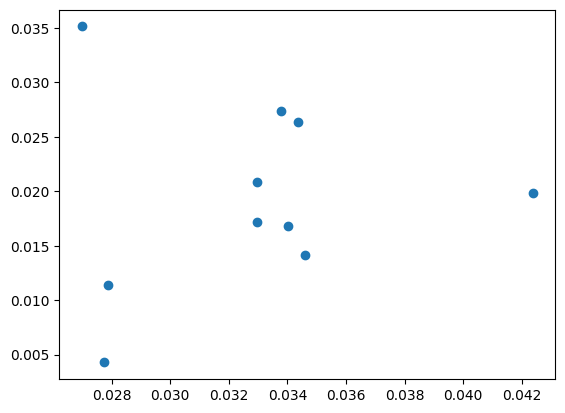

In [81]:
plt.scatter(std[190:], np.abs(gt - pred)[190:])

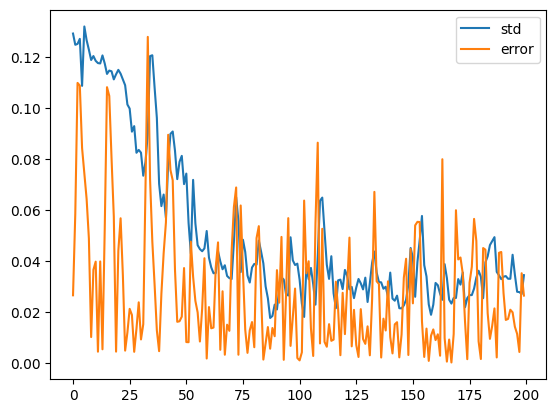

In [84]:
plt.plot(std, label='std')
plt.plot(np.abs(gt - pred), label='error')
plt.legend()

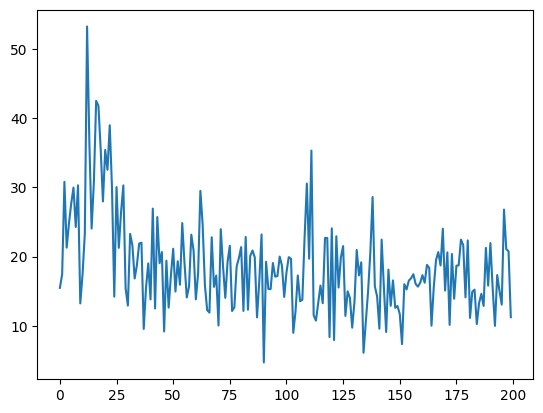

In [85]:
errors = np.array([15.47539745, 17.44397019, 30.78817033, 21.28419971, 24.79396478,
       27.66026975, 29.96456707, 24.26728169, 30.29397974, 13.2310346 ,
       17.42535074, 23.28419758, 53.23462229, 36.55749935, 24.04020143,
       30.7973489 , 42.49065117, 41.79884814, 35.52918826, 27.96077277,
       35.40021226, 32.53168893, 38.96660014, 29.85347899, 14.21274316,
       30.03252521, 21.25500259, 26.42480051, 30.28149969, 15.41759991,
       12.9178949 , 23.27008706, 21.6086203 , 16.82895089, 18.79743661,
       21.87895409, 22.00125198,  9.54317749, 15.44794412, 19.01333836,
       13.80014876, 26.92628086, 12.49717691, 25.70780034, 19.03677824,
       20.6498104 ,  9.18124897, 19.40044981, 12.62054451, 17.30462608,
       21.12969349, 14.94328865, 19.3213725 , 15.9251945 , 24.83562094,
       19.03472276, 14.09341471, 15.70097096, 23.1607766 , 20.87068014,
       13.81705622, 17.56683737, 29.49355252, 24.61875587, 15.87421439,
       12.25322838, 11.90299025, 22.79018581, 15.62695814, 17.25542847,
       10.03422316, 23.95338617, 18.58749637, 14.03467538, 19.23836085,
       21.56090019, 12.13314917, 12.66196473, 18.56003078, 19.78077394,
       21.36169506, 12.14070755, 22.83333237, 12.31541773, 20.0817004 ,
       20.87341062, 19.89332034, 11.21410376, 16.41841444, 23.19517139,
        4.69743814, 19.2470209 , 15.31706645, 15.29669086, 19.05831389,
       17.09953024, 17.17704994, 19.99883716, 18.69012882, 14.16895893,
       17.72118108, 19.90760116, 19.67490871,  8.97890511, 12.12720743,
       17.26132628, 13.5442745 , 13.7550354 , 22.83774503, 30.54412159,
       19.68889209, 35.30473981, 11.51849817, 10.74746987, 13.27398401,
       15.80156688, 13.2526269 , 22.67867689, 22.68439841,  8.3679013 ,
       24.07872488,  7.94471541, 22.93583041, 15.52062893, 19.88130764,
       21.50969279, 11.42368525, 14.97588428, 14.0076376 ,  9.72582934,
       13.4125143 , 20.94330359, 17.27508727, 19.16708288,  6.10238234,
       10.58462108, 14.91038961, 20.52936792, 28.59901977, 15.69965183,
       14.23586942,  9.57203451, 22.44960966, 15.456284  ,  9.09759527,
       18.11795496, 12.88257599, 16.55282091, 12.59326203, 12.85178877,
       11.69105337,  7.3467821 , 16.01071842, 15.25110446, 16.5203786 ,
       16.87061697, 17.44585412, 16.0456713 , 15.65293585, 16.1952249 ,
       17.31655722, 16.21348564, 18.79400088, 18.3680536 , 10.01395848,
       15.5768894 , 19.50263555, 20.64570708, 18.71535775, 24.02379347,
       15.08698052, 20.60109188, 10.12797782, 20.36351684, 13.90583943,
       18.67687499, 18.72861624, 22.44497801, 21.65460905, 14.09991726,
       22.32944761, 11.13302968, 14.91479536, 15.21706345, 10.24394881,
       13.27949641, 14.61509574, 12.86511299, 21.25787913, 15.79811782,
       21.94783814, 15.41301818,  9.98226547, 17.32432219, 15.06089881,
       13.05683558, 26.78384058, 21.05281351, 20.77739715, 11.23868924])

plt.plot(errors)

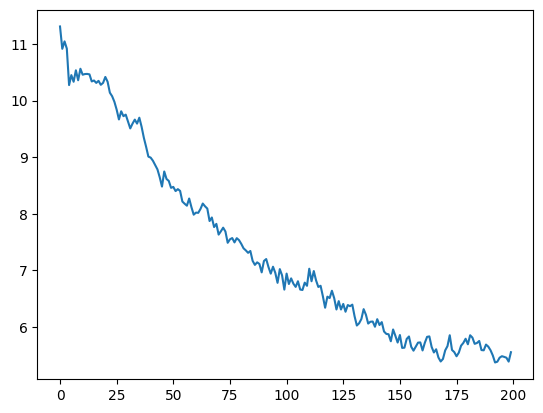

In [86]:
std_arr = np.array([11.31060353, 10.91544633, 11.04703226, 10.91955801, 10.2746237 ,
       10.4507596 , 10.33297693, 10.53585218, 10.35982745, 10.56333917,
       10.45770583, 10.46972003, 10.47182118, 10.46384248, 10.33892206,
       10.35557112, 10.31272338, 10.34948068, 10.27910376, 10.31328117,
       10.41815939, 10.33313423, 10.13986009, 10.07744263,  9.97904731,
        9.83951106,  9.66675878,  9.81093355,  9.72465467,  9.75216984,
        9.63232195,  9.50819718,  9.59300506,  9.66390398,  9.59305968,
        9.69782277,  9.53780347,  9.34206044,  9.18206508,  9.00934092,
        8.99198784,  8.93673448,  8.85876564,  8.78333794,  8.64500667,
        8.4795813 ,  8.7466961 ,  8.6144615 ,  8.57982178,  8.45748574,
        8.47402284,  8.40016523,  8.4347407 ,  8.40314892,  8.21529574,
        8.17631159,  8.14195974,  8.268622  ,  8.11549105,  7.98312376,
        8.01966037,  8.01552169,  8.08510311,  8.17984419,  8.1310268 ,
        8.09101792,  7.87075119,  7.93322457,  7.76414121,  7.82043152,
        7.63074352,  7.68940063,  7.75325773,  7.6852994 ,  7.48590966,
        7.54717901,  7.56959173,  7.49272239,  7.56756901,  7.5326355 ,
        7.46646496,  7.38810226,  7.35137488,  7.30845406,  7.34106667,
        7.16723004,  7.0953839 ,  7.14022772,  7.11174837,  6.96292981,
        7.16450599,  7.19824756,  7.05692882,  6.94052438,  7.0628201 ,
        6.9557371 ,  6.77769617,  7.02056041,  6.90997665,  6.65843469,
        6.94159465,  6.7570907 ,  6.8567655 ,  6.76272298,  6.70608275,
        6.80597934,  6.65897359,  6.651387  ,  6.7812621 ,  6.72540694,
        7.02707286,  6.80575588,  6.98634754,  6.82102287,  6.70451575,
        6.72614394,  6.54149929,  6.33751485,  6.53333027,  6.50841388,
        6.63793412,  6.50800359,  6.30667552,  6.45435454,  6.30650723,
        6.40472521,  6.26686629,  6.38502718,  6.36519664,  6.39208995,
        6.18628088,  6.02321194,  6.06266708,  6.13874937,  6.31246656,
        6.21461928,  6.05777592,  6.09008766,  6.09382119,  6.00155132,
        6.13508437,  6.03206059,  6.08314684,  5.91743026,  5.87531173,
        5.86854534,  5.74491689,  5.95314154,  5.84165356,  5.72231014,
        5.85538311,  5.6269392 ,  5.63146687,  5.78620378,  5.82936465,
        5.64731429,  5.57855197,  5.65140059,  5.72029583,  5.72426375,
        5.58239189,  5.71809228,  5.82272496,  5.8307837 ,  5.64561209,
        5.54650354,  5.60316467,  5.4576921 ,  5.38728552,  5.43169772,
        5.58428244,  5.65894732,  5.85172867,  5.59080945,  5.55273157,
        5.47951192,  5.54348312,  5.66659753,  5.71539355,  5.78936151,
        5.69158023,  5.85108799,  5.80966788,  5.69937087,  5.71409117,
        5.75005143,  5.58888557,  5.58484057,  5.68594253,  5.65015983,
        5.58583886,  5.4941522 ,  5.36967231,  5.38344294,  5.45377855,
        5.4806713 ,  5.4687121 ,  5.45424926,  5.3851069 ,  5.55131841])

plt.plot(std_arr)

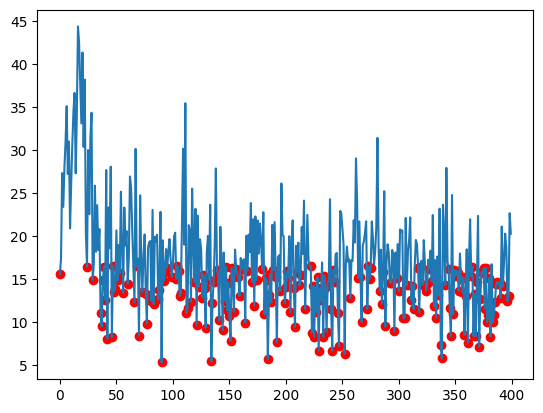

In [95]:
errors = np.array([15.54226744, 17.33352732, 27.31567156, 23.38384909, 27.91651568,
       30.94482793, 35.10291331, 27.20664482, 30.98495268, 20.87604175,
       26.1475406 , 30.74326869, 34.50244834, 36.64944673, 27.28941956,
       34.24501865, 44.37556826, 42.42568359, 37.92583881, 33.09952357,
       41.3505004 , 30.35401486, 38.18909239, 20.27923197, 16.44066921,
       30.00092682, 22.53927145, 31.40173929, 34.34539946, 14.87787521,
       16.69555176, 25.85595502, 18.15896606, 23.5798906 , 18.37538693,
       20.80261897, 11.02386279,  9.47230246, 14.86955879, 16.43619235,
       12.57622975, 27.66963119,  8.05503249, 23.32066097, 18.57486779,
       28.06269057,  8.24176416, 16.48181231, 13.51107297, 13.77557582,
       20.65126847, 14.83282089, 18.95003702, 15.69589503, 25.15161108,
       18.69146598, 13.38005645, 23.30639234, 18.88197095, 20.57443889,
       14.44080293, 17.52000822, 26.92583929, 25.60155547, 20.75154002,
       16.49527369, 12.27903219, 30.13772593, 16.46347079, 17.35840936,
        8.40177835, 24.72502226, 17.26530262, 13.50401712, 17.81305142,
       20.17096345, 13.25487329,  9.79805881, 18.63059627, 19.27939437,
       19.40351967, 12.43907875, 23.03394175, 12.06122728, 19.92080187,
       19.37470331, 20.14654746, 12.62175211, 13.66046642, 22.80078009,
        5.28027091, 19.49624155, 14.80677608, 15.75307463, 18.48001767,
       16.31656173, 18.21909037, 19.63319226, 17.26398216, 15.22157353,
       16.83784885, 19.93270421, 20.37551626, 14.98910832, 16.45829494,
       15.9154952 , 13.01743516, 13.34386186, 21.2141051 , 30.15030863,
       18.99035378, 35.44365563, 11.04208721, 11.62496981, 21.26050961,
       20.65939875, 12.36018546, 25.5089743 , 19.18549023, 14.64703377,
       23.1640329 ,  9.63918088, 22.35849939, 14.09128445, 19.6206218 ,
       18.411195  , 12.83911453, 15.43887598, 13.94702703,  9.31273681,
       18.07894699, 20.01204109, 14.91233694, 23.63245095,  5.40926899,
       12.18489755, 14.59518401, 18.9774827 , 27.85968492, 16.0411281 ,
       15.44042821, 10.18502647, 21.06646427, 16.74827316,  9.03579364,
       18.06946498, 12.45393494, 16.40499613, 11.3491598 , 14.56135661,
       10.6723775 ,  7.80840445, 16.26668496, 15.20271753, 11.20387462,
       18.41863604, 16.13533521, 15.5645042 , 15.23687934, 13.03341183,
       17.43366513, 16.16454121, 17.18853003, 17.28976315,  9.90102923,
       20.01691635, 15.95002197, 20.14809264, 18.13430741, 23.83528688,
       14.63790952, 21.95345953, 11.90973152, 22.28076523, 14.86228505,
       21.79768966, 17.94715014, 21.44446689, 19.33327708, 16.13880013,
       22.76066593, 10.88590162, 15.07492943, 14.84901389,  5.68828661,
       13.08451026, 15.54865824, 12.27822313, 21.29140073, 16.03358926,
       21.60949501, 15.19749055,  7.63893709, 17.54071924, 17.75273836,
       13.59325197, 26.10533054, 20.0760962 , 19.98882149, 12.16685414,
       14.05000004, 15.91314247, 15.16574007, 19.9791888 , 11.12657904,
       18.93529639, 21.81468094, 13.98212536,  9.42214001, 18.85293625,
       15.7739187 , 19.2259438 , 14.23926831, 15.45759487, 21.03630569,
       17.89661642, 24.11665084, 11.48132131, 16.69513543, 22.44988151,
       17.22389898, 16.53043629, 16.46423431,  8.76125599, 14.12657127,
        8.26919034, 14.09349555, 11.1542569 , 15.19229978,  6.65893957,
       13.91417688, 12.49980013, 16.92344302,  8.26585912, 15.35862663,
       13.94081606,  8.864304  , 14.47196929, 15.12998026, 24.28034841,
       11.50317103,  6.63184937, 15.99855907, 14.68784189, 17.86731877,
       18.02393189, 11.08036721,  7.1686629 , 22.91375048, 22.62987987,
       20.81235335, 19.0540073 ,  6.30448238, 16.66978209, 18.77308336,
       16.98057236, 17.28722192, 12.77573469, 17.18140177, 17.09294501,
       21.82399349, 19.24053511, 29.02402952, 24.05074652, 15.11614581,
       21.69478115, 15.24353082, 10.00496393, 18.91607837, 19.38094824,
       20.42939894, 21.70766464, 11.53003708, 16.46251614, 15.01426999,
       16.31510235, 21.68660029, 19.70946617, 16.7232498 , 18.23894736,
       21.05265656, 31.41066819, 18.79729237, 13.6376099 , 18.40648902,
       12.10478498, 15.7892723 , 25.20338361,  9.47558019, 16.88445327,
       19.02689519, 18.10377663, 14.55404947, 14.55542422, 18.37144465,
       17.85769605,  8.89922028, 18.07660209, 15.13654246, 19.05943734,
       13.59699631, 20.77591632, 20.48522191, 20.65686247, 10.4494346 ,
       10.44356638, 22.09941197, 14.26242793, 18.16607224, 19.44043257,
       22.16854687, 12.49322074, 14.22916694, 11.45731069, 16.60061271,
       19.53074954, 19.03821861, 16.24276792, 11.10122146, 16.34062103,
       17.11068278, 14.28627668, 19.51701177, 16.7729806 , 13.64730075,
       14.46042856, 17.23893947, 16.21298144, 18.28484668, 14.70269706,
       22.43822113, 11.79808421, 17.17963901, 10.48923746, 17.60650969,
       13.10191462, 23.17587061,  7.30405534,  5.7762929 , 23.62797317,
       20.20352877, 14.31128029, 27.92081009, 17.05797358, 16.16837851,
       11.61007328,  8.34224971, 24.76772196, 10.87699537, 16.04550732,
       15.3457737 , 15.94526331, 15.64164028, 13.59382433, 17.96784658,
       15.040601  , 13.52425849, 15.18737952,  8.49148812, 13.00360223,
       18.44801276,  7.55466709, 17.32935976, 21.94510746, 15.33997353,
       16.42436403,  8.32310766, 13.27131344,  8.36128889, 14.58948582,
       22.33244458,  7.12551822, 12.62067185, 15.75615936, 15.6832852 ,
       16.22465045, 11.53772887, 16.27266316,  9.97350635, 10.78330474,
       15.11144883,  8.26747415, 16.71829525,  9.94461472, 10.84401613,
       12.35077397, 14.3596729 , 14.62489005, 14.44476005, 14.58216653,
       12.79329015, 21.09687091, 14.12311881, 16.89979627, 20.27365493,
       18.68504458, 12.40286037, 12.98455092, 22.65029652, 20.26660387])
indices_gt = errors.argsort()
percentage_to_keep = 50
n_to_keep = int(percentage_to_keep * len(errors) / 100)
plt.plot(errors)
plt.scatter(indices_gt[:n_to_keep], errors[indices_gt[:n_to_keep]], color='red')

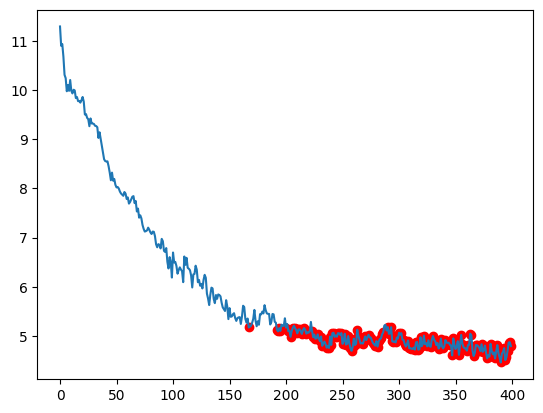

In [96]:
stds_norm = np.array([11.29738688, 10.90409886, 10.93975559, 10.68273424, 10.31315254,
       10.24574809,  9.97906463, 10.10637635,  9.9876756 , 10.20762137,
        9.98699117,  9.93500714, 10.00978923,  9.99608137,  9.84067782,
        9.86086128,  9.77709483,  9.78181355,  9.74732182,  9.79636563,
        9.86218326,  9.76844054,  9.50450296,  9.51371648,  9.43715089,
        9.40984981,  9.26744319,  9.42546538,  9.3231087 ,  9.32133588,
        9.31281213,  9.27613781,  9.27086479,  9.24594779,  9.02907767,
        9.14377433,  9.00638232,  8.87175022,  8.72585351,  8.5953698 ,
        8.55705002,  8.55007413,  8.55187972,  8.451003  ,  8.32169576,
        8.16736793,  8.32206439,  8.15837426,  8.19357119,  8.07479253,
        8.02155118,  8.0304709 ,  7.99953411,  7.93702746,  7.89699633,
        7.87501374,  7.85052892,  7.92735392,  7.89507837,  7.78571674,
        7.8169954 ,  7.69179476,  7.72505774,  7.78034402,  7.83193433,
        7.84370269,  7.70143148,  7.74412261,  7.5312695 ,  7.59056772,
        7.40528509,  7.45340814,  7.39175326,  7.25718915,  7.17788946,
        7.12286942,  7.13157525,  7.14657443,  7.20221867,  7.15908849,
        7.10528165,  7.07345603,  7.12204247,  7.11812298,  7.03233418,
        6.86479042,  6.80301271,  6.86690969,  6.85210397,  6.77932567,
        6.97393011,  6.92581895,  6.72966583,  6.70816135,  6.78675167,
        6.5058111 ,  6.37177214,  6.60155636,  6.49872272,  6.18667716,
        6.69621397,  6.49390536,  6.50536739,  6.42459872,  6.26543278,
        6.34024921,  6.39379219,  6.34925956,  6.31574706,  6.09286127,
        6.61484192,  6.4447984 ,  6.58731328,  6.3836753 ,  6.36613335,
        6.33567236,  6.23041328,  5.98482869,  6.25022928,  6.26098309,
        6.42777371,  6.34805449,  6.09178987,  6.13832308,  6.02000668,
        6.05769634,  5.96467465,  6.13714325,  6.24187106,  6.18122255,
        5.85889908,  5.75865197,  5.62686298,  5.8356535 ,  5.98067676,
        5.96593151,  5.75065356,  5.66546379,  5.83093994,  5.7535926 ,
        5.84295791,  5.83057001,  5.8044096 ,  5.67446306,  5.57938406,
        5.54407843,  5.50596687,  5.72547268,  5.59634805,  5.34082493,
        5.56444613,  5.38808519,  5.39436404,  5.43983831,  5.46071179,
        5.36186663,  5.30425422,  5.36181829,  5.37496403,  5.38122992,
        5.24241934,  5.39081382,  5.61240789,  5.58663007,  5.34495551,
        5.26897611,  5.35249307,  5.17107516,  5.18382892,  5.20704503,
        5.26478314,  5.347953  ,  5.52770661,  5.31199499,  5.19464723,
        5.29695584,  5.22504354,  5.44228206,  5.43560789,  5.49288373,
        5.45643503,  5.62471383,  5.5222653 ,  5.45721686,  5.44739348,
        5.44673568,  5.23130221,  5.28131622,  5.44516924,  5.43652211,
        5.28623235,  5.26783046,  5.12145459,  5.09224005,  5.15573147,
        5.10090279,  5.22806607,  5.20409964,  5.20214401,  5.35711109,
        5.16798262,  5.24212846,  5.09650204,  5.10788189,  4.98036202,
        5.09910792,  5.16325282,  5.20458711,  5.15680089,  5.11615908,
        5.04993171,  5.13015493,  5.1308157 ,  5.09432744,  5.04044508,
        5.12233866,  5.15726828,  5.11897609,  5.04606381,  5.07182513,
        5.06392008,  5.09436856,  5.28308688,  5.10170075,  4.97315766,
        5.02650798,  4.94272379,  4.95231194,  5.02966664,  4.94506801,
        4.89096136,  4.98621481,  4.79666981,  4.84828468,  4.8821795 ,
        4.82876038,  4.75937304,  4.79602963,  4.75295566,  4.98507629,
        4.81614708,  5.05323491,  5.06323227,  4.97849038,  5.00844723,
        4.98241499,  5.05517269,  5.05133645,  5.01826193,  5.05614979,
        4.83704252,  4.90092396,  5.0423871 ,  4.82213875,  4.83493642,
        4.99507503,  4.84807852,  4.74659578,  4.69489533,  4.77406414,
        4.94207636,  4.81337436,  4.83921816,  5.12380813,  4.99952638,
        4.91782412,  4.84420918,  4.85346002,  4.84263108,  4.91674524,
        4.9879963 ,  4.91328211,  4.97480951,  5.02158223,  4.96591879,
        4.96419115,  4.90275795,  4.8502089 ,  4.82715714,  4.799885  ,
        4.89232753,  4.78085082,  4.8857699 ,  4.9342051 ,  4.94859675,
        5.02980527,  5.07351152,  5.20977872,  5.2233041 ,  5.10792167,
        5.17819851,  5.03996073,  5.05016029,  5.17556479,  4.88705793,
        4.87880284,  4.88536957,  4.86608406,  4.96489224,  4.94479015,
        5.06370215,  5.02609669,  5.0538496 ,  4.9233383 ,  4.91400134,
        4.83444946,  4.78329222,  4.82891963,  4.90475631,  4.74761777,
        4.74913048,  4.73820641,  4.73389918,  4.76044284,  4.71892505,
        4.86835947,  4.87430092,  4.71976902,  4.72706622,  4.9721786 ,
        4.7879186 ,  4.83274815,  5.00454799,  4.82892806,  4.8512412 ,
        4.78574039,  4.90895051,  4.7874267 ,  4.77722792,  4.92488007,
        4.99561536,  4.92249705,  4.88751818,  4.81230551,  4.85401076,
        4.74092368,  4.77814142,  4.94507441,  4.78819621,  4.74411134,
        4.78352156,  4.91509695,  4.86285432,  4.85767003,  4.86016477,
        4.81609316,  4.80374636,  4.60145165,  4.94782068,  4.81122747,
        4.73139809,  4.78944263,  4.89064932,  4.61362182,  4.81845392,
        5.01766881,  4.83940595,  4.77612929,  4.74573822,  4.74433144,
        4.69933391,  4.81191029,  4.81740104,  5.04325529,  5.00784227,
        4.70049407,  4.59033187,  4.6503958 ,  4.81388591,  4.80850786,
        4.79237848,  4.75307558,  4.68972952,  4.82787142,  4.67573324,
        4.70656682,  4.80172748,  4.65858379,  4.54167437,  4.60640294,
        4.57707326,  4.83650986,  4.69243507,  4.62588253,  4.66268295,
        4.53980553,  4.68835671,  4.81210601,  4.64290616,  4.55931402,
        4.45776595,  4.63595397,  4.67547526,  4.74892205,  4.50734881,
        4.56023767,  4.69276068,  4.86253457,  4.86975368,  4.7917971 ])
indices_gt = stds_norm.argsort()
percentage_to_keep = 50
n_to_keep = int(percentage_to_keep * len(stds_norm) / 100)
plt.plot(stds_norm)
plt.scatter(indices_gt[:n_to_keep], stds_norm[indices_gt[:n_to_keep]], color='red')

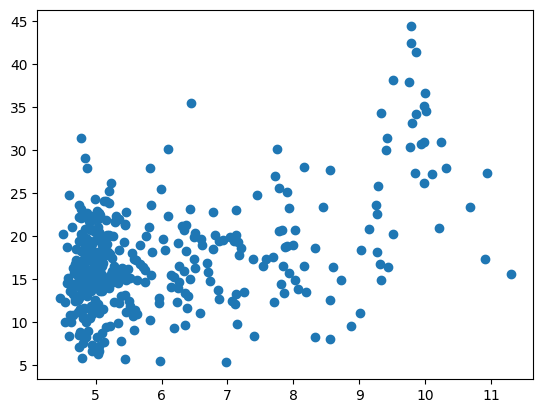

In [100]:
plt.scatter(stds_norm, errors)